<div class="alert alert-block alert-success">

###**GAMZE ÖNDER**
October 2024

### ***Project Description: Sentiment Analysis of YouTube Comments on Presidential Candidates***


This project aims to analyze public sentiment regarding U.S. presidential candidates Kamala Harris and Donald Trump based on comments retrieved from a YouTube video titled ['Full Debate: Harris vs. Trump in 2024 ABC News Presidential Debate — WSJ.](https://www.youtube.com/watch?v=VgsC_aBquUE)'


The goal is to predict the likely winner of the 2024 election based on sentiment trends observed in the comments.

<br>

***The analysis includes the following steps:***

**1.** Data collection using the YouTube API to retrieve comments from the specified video.

**2.** Data cleaning and preprocessing to prepare the text for sentiment analysis.

**3.** Using both classical machine learning models (Logistic Regression, Random Forest) and deep learning models (DistilBERT) to classify comments as positive, neutral, or negative for each candidate.

**4.** Comparing model performance using evaluation metrics such as accuracy, precision, recall, and F1-score.

**5.** Visualizing the classification results and evaluating the sentiment trends for each candidate.

**6.** Conducting emotion detection to provide further insights into the emotional undertones present in the comments.

<br>

The goal is to provide a comprehensive analysis that not only predicts the overall sentiment toward each candidate but also highlights the key emotional aspects expressed in the public comments. This project uses a combination of classical ML techniques and transformer-based models to ensure a thorough exploration of sentiment and emotions in the collected data.


### ⚠️ Important Notices
- I highly recommend to you run this code on google collabs because training part takes too much time. (I worked with T4 GPU.)
- I uploaded the files in case there is an issue with the code or if it takes too much time to run.

## 0. Connecting Google Colabs

This section explains how to connect Google Colab to VS Code.  [This link]( https://github.com/amitness/colab-connect?tab=readme-ov-file) has more information.

In [1]:
#!pip install -U git+https://github.com/amitness/colab-connect.git


In [2]:
#from colabconnect import colabconnect

#colabconnect()

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Scraping Data YouTube Comments

In [4]:
!pip install google-api-python-client
import sqlite3
import csv
from googleapiclient.discovery import build
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# API configuration
api_service_name = "youtube"
api_version = "v3"
DEVELOPER_KEY = "XXXXX"  # Please replace with your actual API key

# Build the YouTube service
youtube = build(api_service_name, api_version, developerKey=DEVELOPER_KEY)

Every time we collect more comments, the video comments total around 85,000. However, we can start by analyzing approximately half of them, which is a good initial number for analysis.


### Database connection code explanation

This script is created to collect comments from a YouTube video, save them to a database, and export them to a CSV file. Below is a breakdown of what each part of the code does:

<br>

**1.** Establishes a connection to a SQLite database named **youtube_comments.db** and creates a **cursor** object to execute SQL commands.

**2.** Creates a table called comments in the database to store YouTube comments if it doesn't already exist. The table includes columns such as **comment_id, video_id, author, text, like_count, etc.**

**3.** **save_comment():** Inserts a comment into the comments table. If the comment already exists (comment_id is the primary key), it ignores the duplicate.

**4.** **get_new_comments(video_id):** Retrieves comments from a specific YouTube video using the YouTube Data API. It collects information such as the **author, text, like_count, and more**, then saves it to the database using **save_comment()**. It uses pagination to retrieve all available comments.

**5.** **export_comments_to_csv(filename):** Exports all comments stored in the database to a CSV file. This is useful for further analysis in tools like Excel or Python data analysis libraries.

**6.**  
- Defines the video ID and calls **get_new_comments(video_id)** to collect the comments.

- Exports the collected comments to a CSV file named **youtube_comments.csv**.

- Closes the database connection to ensure all resources are properly released.

In [6]:
# '''''
# Database connection
conn = sqlite3.connect("youtube_comments.db")
cursor = conn.cursor()

# Create comments table with additional columns
cursor.execute("""
CREATE TABLE IF NOT EXISTS comments (
    comment_id TEXT PRIMARY KEY,
    video_id TEXT,
    channel_id TEXT,
    author TEXT,
    text TEXT,
    like_count INTEGER,
    total_reply INTEGER,
    channel_url TEXT,
    published_at TEXT,
    updated_at TEXT
)
""")
conn.commit()

# Function to save comments to the database
def save_comment(comment_id, video_id, channel_id, author, text, like_count, total_reply, channel_url, published_at, updated_at):
    cursor.execute("""
        INSERT OR IGNORE INTO comments (comment_id, video_id, channel_id, author, text, like_count, total_reply, channel_url, published_at, updated_at)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    """, (comment_id, video_id, channel_id, author, text, like_count, total_reply, channel_url, published_at, updated_at))
    conn.commit()

# Function to retrieve new comments
def get_new_comments(video_id):
    next_page_token = None
    new_comments_count = 0  # Initialize new comments counter

    while True:
        request = youtube.commentThreads().list(
            part="snippet",
            videoId=video_id,
            textFormat="plainText",
            maxResults=100,
            pageToken=next_page_token
        )
        response = request.execute()

        for item in response["items"]:
            # Extract comment details
            comment_id = item["id"]
            snippet = item["snippet"]["topLevelComment"]["snippet"]
            channel_id = snippet.get("authorChannelId", {}).get("value", "")
            author = snippet["authorDisplayName"]
            text = snippet["textDisplay"]
            like_count = snippet["likeCount"]
            total_reply = item["snippet"]["totalReplyCount"]
            channel_url = snippet.get("authorChannelUrl", "")
            published_at = snippet["publishedAt"]
            updated_at = snippet.get("updatedAt", "")

            # Save the comment to the database
            save_comment(comment_id, video_id, channel_id, author, text, like_count, total_reply, channel_url, published_at, updated_at)

            # Increase the new comments count
            new_comments_count += 1

        # Get the next page token
        next_page_token = response.get("nextPageToken")
        if not next_page_token:
            break

    print(f"Number of new comments retrieved: {new_comments_count}")

# Function to export comments to CSV
def export_comments_to_csv(filename):
    cursor.execute("SELECT * FROM comments")
    rows = cursor.fetchall()

    with open(filename, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(["Comment ID", "Video ID", "Channel ID", "Author", "Text", "Like Count", "Total Reply", "Channel URL", "Published At", "Updated At"])  # Write header

        for row in rows:
            writer.writerow(row)  # Write each comment row

    print(f"Comments exported to {filename}")

# Define the video ID
video_id = "VgsC_aBquUE"
get_new_comments(video_id)

# Export comments to CSV
export_comments_to_csv("youtube_comments.csv")

# Close the database connection
conn.close()
# '''''

Number of new comments retrieved: 44833
Comments exported to youtube_comments.csv


In [7]:
df = pd.read_csv("youtube_comments.csv")
df.head()

,Comment ID,Video ID,Channel ID,Author,Text,Like Count,Total Reply,Channel URL,Published At,Updated At
0,UgzMqNF6Zz61EFFFBRh4AaABAg,VgsC_aBquUE,UCK7tptUDHh-RYDsdxO1-5QQ,@wsj,Read analysis from the debate here: http://on....,1168,301,http://www.youtube.com/@wsj,2024-09-11T14:03:41Z,2024-09-11T14:03:59Z
1,UgxQPhF5U-kMtPEmhQt4AaABAg,VgsC_aBquUE,UCPFt9In0UHtT5_qBqU_y71A,@keithloy8775,Coming back here after the election result is ...,1,0,http://www.youtube.com/@keithloy8775,2024-11-16T18:14:21Z,2024-11-16T18:14:21Z
2,Ugwt_-luGRLr0uV_6M14AaABAg,VgsC_aBquUE,UCmHKcKX1PuVJPmnPCvfij9A,@Gabiii47,She has the voice of Janice from Friends.,0,0,http://www.youtube.com/@Gabiii47,2024-11-16T17:37:08Z,2024-11-16T17:37:08Z
3,UgzbcvO3E0u1dnDS8np4AaABAg,VgsC_aBquUE,UCmMEqtR8W1E2PM4SJzFr1-Q,@menatube7808,I m not american . I watch it as a movie,0,0,http://www.youtube.com/@menatube7808,2024-11-16T14:54:28Z,2024-11-16T14:54:28Z
4,Ugx1OFVp2gpRB_3mxvN4AaABAg,VgsC_aBquUE,UCxyxGtuTRwqWY2eHRyZanhw,@jave4868,25:50 she definitely wanted to laugh,0,0,http://www.youtube.com/@jave4868,2024-11-16T14:26:59Z,2024-11-16T14:26:59Z


Here, dates appear as objects, so we need to convert them to datetime format.

In [8]:
df.dtypes

,0
Comment ID,object
Video ID,object
Channel ID,object
Author,object
Text,object
Like Count,int64
Total Reply,int64
Channel URL,object
Published At,object
Updated At,object


In [9]:
df.shape

(44832, 10)

In [10]:
def change_data_type_into_datetime(df):

    df["Published At"] = pd.to_datetime(df["Published At"])
    df["Updated At"] = pd.to_datetime(df["Updated At"])


    return change_data_type_into_datetime

change_data_type_into_datetime(df)


df.dtypes

,0
Comment ID,object
Video ID,object
Channel ID,object
Author,object
Text,object
Like Count,int64
Total Reply,int64
Channel URL,object
Published At,"datetime64[ns, UTC]"
Updated At,"datetime64[ns, UTC]"


In [11]:
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
df.head(37)

,Comment ID,Video ID,Channel ID,Author,Text,Like Count,Total Reply,Channel URL,Published At,Updated At
0,UgzMqNF6Zz61EFFFBRh4AaABAg,VgsC_aBquUE,UCK7tptUDHh-RYDsdxO1-5QQ,@wsj,Read analysis from the debate here: http://on....,1168,301,http://www.youtube.com/@wsj,2024-09-11 14:03:41+00:00,2024-09-11 14:03:59+00:00
1,UgxQPhF5U-kMtPEmhQt4AaABAg,VgsC_aBquUE,UCPFt9In0UHtT5_qBqU_y71A,@keithloy8775,Coming back here after the election result is ...,1,0,http://www.youtube.com/@keithloy8775,2024-11-16 18:14:21+00:00,2024-11-16 18:14:21+00:00
2,Ugwt_-luGRLr0uV_6M14AaABAg,VgsC_aBquUE,UCmHKcKX1PuVJPmnPCvfij9A,@Gabiii47,She has the voice of Janice from Friends.,0,0,http://www.youtube.com/@Gabiii47,2024-11-16 17:37:08+00:00,2024-11-16 17:37:08+00:00
3,UgzbcvO3E0u1dnDS8np4AaABAg,VgsC_aBquUE,UCmMEqtR8W1E2PM4SJzFr1-Q,@menatube7808,I m not american . I watch it as a movie,0,0,http://www.youtube.com/@menatube7808,2024-11-16 14:54:28+00:00,2024-11-16 14:54:28+00:00
4,Ugx1OFVp2gpRB_3mxvN4AaABAg,VgsC_aBquUE,UCxyxGtuTRwqWY2eHRyZanhw,@jave4868,25:50 she definitely wanted to laugh,0,0,http://www.youtube.com/@jave4868,2024-11-16 14:26:59+00:00,2024-11-16 14:26:59+00:00
5,UgxZpXaBILHY9DWJdgJ4AaABAg,VgsC_aBquUE,UCwimCS89yCJdMq5AX8PEfGg,@AnimeFridays,I rewatch this to gain inspiration and joy in ...,0,0,http://www.youtube.com/@AnimeFridays,2024-11-16 13:45:38+00:00,2024-11-16 13:45:38+00:00
6,UgwJtswm_NLGqQtPyjF4AaABAg,VgsC_aBquUE,UCt8MS5pv4nvnltICNHNHZhA,@Allbrakesnogarage,81 million false votes 50 mule team corrupt pe...,0,0,http://www.youtube.com/@Allbrakesnogarage,2024-11-16 10:10:07+00:00,2024-11-16 10:10:07+00:00
7,UgwxS98MuiQjdSY0frJ4AaABAg,VgsC_aBquUE,UCuZ-OB6fEHuJHDUg0hfrIPQ,@joshuawagner9316,God bless President Trump. That's my president...,0,0,http://www.youtube.com/@joshuawagner9316,2024-11-16 07:12:07+00:00,2024-11-16 07:12:07+00:00
8,UgymNGLF-4jZLxMPVPJ4AaABAg,VgsC_aBquUE,UC7ZDR5_IlCjPURctNld0vCA,@榊原-c3k,英会話の勉強につかっています,0,0,http://www.youtube.com/@%E6%A6%8A%E5%8E%9F-c3k,2024-11-16 06:49:12+00:00,2024-11-16 06:49:12+00:00
9,Ugzn890xsebRs5QRWyR4AaABAg,VgsC_aBquUE,UCWbbqZI0zYmFYIOi0-bZkwg,@mumbogumboo,"59:45 ""He hates her. He can't stand her.""\nI c...",0,0,http://www.youtube.com/@mumbogumboo,2024-11-16 06:40:53+00:00,2024-11-16 06:40:53+00:00


In [12]:
df.duplicated().sum()

0

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44832 entries, 0 to 44831
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   Comment ID    44832 non-null  object             
 1   Video ID      44832 non-null  object             
 2   Channel ID    44832 non-null  object             
 3   Author        44812 non-null  object             
 4   Text          44824 non-null  object             
 5   Like Count    44832 non-null  int64              
 6   Total Reply   44832 non-null  int64              
 7   Channel URL   44832 non-null  object             
 8   Published At  44832 non-null  datetime64[ns, UTC]
 9   Updated At    44832 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](2), int64(2), object(6)
memory usage: 3.4+ MB


In [14]:
df[['Text']].head(50)

,Text
0,Read analysis from the debate here: http://on....
1,Coming back here after the election result is ...
2,She has the voice of Janice from Friends.
3,I m not american . I watch it as a movie
4,25:50 she definitely wanted to laugh
5,I rewatch this to gain inspiration and joy in ...
6,81 million false votes 50 mule team corrupt pe...
7,God bless President Trump. That's my president...
8,英会話の勉強につかっています
9,"59:45 ""He hates her. He can't stand her.""\nI c..."


Here is our data I don't clean for now I will save this with sorting by like count and then I will save this data set like this.

In [15]:
df = df.sort_values(by=["Like Count"], ascending = False, ignore_index = True)

df.head(10)

,Comment ID,Video ID,Channel ID,Author,Text,Like Count,Total Reply,Channel URL,Published At,Updated At
0,UgyeMwdqH_DFwRsT_0d4AaABAg,VgsC_aBquUE,UCcZnbeR3gNJWfRp-OjiBunA,@robertsterling951,"No matter what your political views are, atlea...",60083,605,http://www.youtube.com/@robertsterling951,2024-09-11 04:44:54+00:00,2024-09-11 04:44:54+00:00
1,Ugy719erGB65zkDAVaJ4AaABAg,VgsC_aBquUE,UCpw230V66mcMWady3nqg6Gw,@WAGNERLEONARD,Americans: This is a Presidential Debate.\n \n...,56839,750,http://www.youtube.com/@WAGNERLEONARD,2024-09-11 07:09:31+00:00,2024-09-11 07:09:31+00:00
2,UgxA5S3tFQBlEVZ5Xuh4AaABAg,VgsC_aBquUE,UC9EwtMJeMu-VPlB_ZZg2ljA,@riropower,Americans watching the debate: 🤔😬🫣\nRest of th...,55961,750,http://www.youtube.com/@riropower,2024-09-11 03:34:24+00:00,2024-09-11 03:34:24+00:00
3,UgypIknkUh8oGeYL8Bp4AaABAg,VgsC_aBquUE,UC970aHD_iI11kCgE3ES1QXg,@ronaldochop4191,Literally any question to Trump:\n\nMillions a...,38338,744,http://www.youtube.com/@ronaldochop4191,2024-09-11 07:03:10+00:00,2024-09-11 07:03:10+00:00
4,UgzehR5QMErYtyDDXmx4AaABAg,VgsC_aBquUE,UCLYZx7WJeQksE5YrGU4NMsA,@GhostdogTrucker,"Trump said they are ""eating people's pets"" is ...",23465,750,http://www.youtube.com/@GhostdogTrucker,2024-09-11 03:09:38+00:00,2024-09-11 03:09:38+00:00
5,UgyGQO2CXxtWGITC8lR4AaABAg,VgsC_aBquUE,UCScl5Bn1tdMSTq-CNab8QyQ,@jazzfan033,"""You and President Trump were elected 4 years ...",23463,303,http://www.youtube.com/@jazzfan033,2024-09-11 05:25:02+00:00,2024-09-11 05:25:02+00:00
6,Ugx68sgB-Mj7V3C33Yp4AaABAg,VgsC_aBquUE,UCoDmpc_OKpiIYBXId-GFHeQ,@Remus88Romulus,America is not a country. It's a company.,22394,537,http://www.youtube.com/@Remus88Romulus,2024-09-11 07:47:08+00:00,2024-09-11 07:47:08+00:00
7,Ugx0nydD0JwqcRU9UM54AaABAg,VgsC_aBquUE,UCFe-LHvKAVol8nL9gt-fbAQ,@oscarhilton-yi6nx,The bravest thing WSJ does is to leave the com...,18378,222,http://www.youtube.com/@oscarhilton-yi6nx,2024-09-11 07:12:41+00:00,2024-09-11 07:12:41+00:00
8,UgzaCp4CL0G8K4-7z_14AaABAg,VgsC_aBquUE,UC2xCqwWdnGPJMBXxC73XcWg,@speedwaytypist4633,“Do you think the economy was better off than ...,16521,422,http://www.youtube.com/@speedwaytypist4633,2024-09-11 05:49:37+00:00,2024-09-11 05:49:37+00:00
9,Ugw6YZBXqyL3aYYpaep4AaABAg,VgsC_aBquUE,UC8fobnfhnWoWrEV_LysA1Pw,@wgriffin3460,"Hide yo wife, hide yo pets, 'cause everybody g...",15882,294,http://www.youtube.com/@wgriffin3460,2024-09-11 05:49:35+00:00,2024-09-11 05:49:35+00:00


We remove timezone information with **tz_localize(None)**  to ensure compatibility with systems that don’t support timezone-aware datetimes, like CSV (Excel too). This also simplifies data handling and calculations, making datetime fields easier to work with uniformly.

In [16]:
!pip install openpyxl
import openpyxl
# Assuming 'published_date' and 'updated_date' are the columns with timezone-aware datetimes
df["Published At"] = df["Published At"].dt.tz_localize(None)
df["Updated At"] = df["Updated At"].dt.tz_localize(None)

df.to_csv("Export Comments Data from Video Debate.csv", index=False, header=True)
pd.read_csv("Export Comments Data from Video Debate.csv")

Output hidden; open in https://colab.research.google.com to view.

There are Nan rows here and we to clean them to avoid noise. We will drop 'Text' and rename empty 'Author' rows as 'Unknown'.

In [17]:
df.isna().sum()

,0
Comment ID,0
Video ID,0
Channel ID,0
Author,20
Text,8
Like Count,0
Total Reply,0
Channel URL,0
Published At,0
Updated At,0


In [18]:
missing_rows = df[df.isnull().any(axis=1)]
missing_rows

,Comment ID,Video ID,Channel ID,Author,Text,Like Count,Total Reply,Channel URL,Published At,Updated At
7050,UgwfPe2bqKjG_jvL0bB4AaABAg,VgsC_aBquUE,UC5TdgFNxD96dJ2cnlgtj7Vg,NaN,The sad part is Trump was attacked so much he ...,3,0,http://www.youtube.com/c/AlaDIST%C3%80NCE,2024-09-11 16:53:33,2024-09-11 16:53:33
7973,UgwF8XYZR5PQEVYpSrN4AaABAg,VgsC_aBquUE,UCricEjDsSqIqkGBVAFqohBA,NaN,Kamala has a plan but you have to elect her to...,2,1,http://www.youtube.com/channel/UCricEjDsSqIqkG...,2024-09-11 17:52:09,2024-09-11 17:52:09
9672,Ugxu1PpWU_ymkJBB-Pt4AaABAg,VgsC_aBquUE,UC4QuyxusyJZsXhmugU4ld5g,NaN,Not Kamala attempting to blame a global pandem...,2,0,http://www.youtube.com/c/EmilieLAbb%C3%A9e,2024-09-11 22:04:49,2024-09-11 22:04:49
9774,UgyJ6EHGsIdvCN2HijZ4AaABAg,VgsC_aBquUE,UC4QuyxusyJZsXhmugU4ld5g,NaN,"Observing Kamala’s extreme expressions, for me...",2,3,http://www.youtube.com/c/EmilieLAbb%C3%A9e,2024-09-11 22:19:18,2024-09-11 22:19:18
11310,UgzB8BTyBDgqz7-x9M94AaABAg,VgsC_aBquUE,UC9nkZKwPo9R_NYxR00XpNzQ,@torbunvathpuppies,NaN,1,0,http://www.youtube.com/@torbunvathpuppies,2024-11-15 17:46:34,2024-11-15 17:46:34
11332,UgxngydL6QUJURZqioZ4AaABAg,VgsC_aBquUE,UCEVxbSVOUC9IX6RbsOFadYA,NaN,To call abortion health care is to call using ...,1,1,http://www.youtube.com/channel/UCEVxbSVOUC9IX6...,2024-09-11 09:14:57,2024-09-11 09:14:57
17764,UgwiB50X_Ra6ouLVOAd4AaABAg,VgsC_aBquUE,UC3E3pK6oDs2Kr4YQM36-ovw,NaN,The sole difference between them is their poli...,1,0,http://www.youtube.com/channel/UC3E3pK6oDs2Kr4...,2024-09-11 13:04:42,2024-09-11 13:04:42
19047,UgwnSN-aPMKBWV1rnqZ4AaABAg,VgsC_aBquUE,UC2mFyxmScs8rFm6fPYxrNdA,NaN,"18th year abortion, think about it",1,0,http://www.youtube.com/c/Cristi%C3%A1nArenasUlloa,2024-09-11 14:19:57,2024-09-11 14:19:57
20286,UgxrUfMkNQoDp9ShNpF4AaABAg,VgsC_aBquUE,UC5TdgFNxD96dJ2cnlgtj7Vg,NaN,"Words mean nothing, Biden said he wouldn’t ban...",1,0,http://www.youtube.com/c/AlaDIST%C3%80NCE,2024-09-11 16:54:36,2024-09-11 16:54:36
20458,UgzRG6JQAWKb8b_20Zt4AaABAg,VgsC_aBquUE,UC5TdgFNxD96dJ2cnlgtj7Vg,NaN,"They really are eating ducks, geese, bald eagl...",1,1,http://www.youtube.com/c/AlaDIST%C3%80NCE,2024-09-11 16:50:07,2024-09-11 16:50:07


In [19]:
df = df.dropna(subset=["Text"])
df["Author"] = df["Author"].fillna("Unknown")
df.isnull().sum()

<ipython-input-19-9759da33438f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Author"] = df["Author"].fillna("Unknown")


,0
Comment ID,0
Video ID,0
Channel ID,0
Author,0
Text,0
Like Count,0
Total Reply,0
Channel URL,0
Published At,0
Updated At,0


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44824 entries, 0 to 44831
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Comment ID    44824 non-null  object        
 1   Video ID      44824 non-null  object        
 2   Channel ID    44824 non-null  object        
 3   Author        44824 non-null  object        
 4   Text          44824 non-null  object        
 5   Like Count    44824 non-null  int64         
 6   Total Reply   44824 non-null  int64         
 7   Channel URL   44824 non-null  object        
 8   Published At  44824 non-null  datetime64[ns]
 9   Updated At    44824 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(6)
memory usage: 3.8+ MB


These are only Comment Ids who made a comment or comments.

In [21]:
df["Channel ID"].value_counts()

Output hidden; open in https://colab.research.google.com to view.

This is only The Wall Sreet Channel ID.

In [22]:
df["Video ID"].value_counts()

,count
Video ID,
VgsC_aBquUE,44824


In [23]:
df = df.sort_values(by=["Like Count"], ascending = False, ignore_index = True)

df.head(14)

,Comment ID,Video ID,Channel ID,Author,Text,Like Count,Total Reply,Channel URL,Published At,Updated At
0,UgyeMwdqH_DFwRsT_0d4AaABAg,VgsC_aBquUE,UCcZnbeR3gNJWfRp-OjiBunA,@robertsterling951,"No matter what your political views are, atlea...",60083,605,http://www.youtube.com/@robertsterling951,2024-09-11 04:44:54,2024-09-11 04:44:54
1,Ugy719erGB65zkDAVaJ4AaABAg,VgsC_aBquUE,UCpw230V66mcMWady3nqg6Gw,@WAGNERLEONARD,Americans: This is a Presidential Debate.\n \n...,56839,750,http://www.youtube.com/@WAGNERLEONARD,2024-09-11 07:09:31,2024-09-11 07:09:31
2,UgxA5S3tFQBlEVZ5Xuh4AaABAg,VgsC_aBquUE,UC9EwtMJeMu-VPlB_ZZg2ljA,@riropower,Americans watching the debate: 🤔😬🫣\nRest of th...,55961,750,http://www.youtube.com/@riropower,2024-09-11 03:34:24,2024-09-11 03:34:24
3,UgypIknkUh8oGeYL8Bp4AaABAg,VgsC_aBquUE,UC970aHD_iI11kCgE3ES1QXg,@ronaldochop4191,Literally any question to Trump:\n\nMillions a...,38338,744,http://www.youtube.com/@ronaldochop4191,2024-09-11 07:03:10,2024-09-11 07:03:10
4,UgzehR5QMErYtyDDXmx4AaABAg,VgsC_aBquUE,UCLYZx7WJeQksE5YrGU4NMsA,@GhostdogTrucker,"Trump said they are ""eating people's pets"" is ...",23465,750,http://www.youtube.com/@GhostdogTrucker,2024-09-11 03:09:38,2024-09-11 03:09:38
5,UgyGQO2CXxtWGITC8lR4AaABAg,VgsC_aBquUE,UCScl5Bn1tdMSTq-CNab8QyQ,@jazzfan033,"""You and President Trump were elected 4 years ...",23463,303,http://www.youtube.com/@jazzfan033,2024-09-11 05:25:02,2024-09-11 05:25:02
6,Ugx68sgB-Mj7V3C33Yp4AaABAg,VgsC_aBquUE,UCoDmpc_OKpiIYBXId-GFHeQ,@Remus88Romulus,America is not a country. It's a company.,22394,537,http://www.youtube.com/@Remus88Romulus,2024-09-11 07:47:08,2024-09-11 07:47:08
7,Ugx0nydD0JwqcRU9UM54AaABAg,VgsC_aBquUE,UCFe-LHvKAVol8nL9gt-fbAQ,@oscarhilton-yi6nx,The bravest thing WSJ does is to leave the com...,18378,222,http://www.youtube.com/@oscarhilton-yi6nx,2024-09-11 07:12:41,2024-09-11 07:12:41
8,UgzaCp4CL0G8K4-7z_14AaABAg,VgsC_aBquUE,UC2xCqwWdnGPJMBXxC73XcWg,@speedwaytypist4633,“Do you think the economy was better off than ...,16521,422,http://www.youtube.com/@speedwaytypist4633,2024-09-11 05:49:37,2024-09-11 05:49:37
9,Ugw6YZBXqyL3aYYpaep4AaABAg,VgsC_aBquUE,UC8fobnfhnWoWrEV_LysA1Pw,@wgriffin3460,"Hide yo wife, hide yo pets, 'cause everybody g...",15882,294,http://www.youtube.com/@wgriffin3460,2024-09-11 05:49:35,2024-09-11 05:49:35


## 2. Text Processing  (Case Folding, Removal Punctuations) for Column Text Comments

In [24]:
df.head(20)

,Comment ID,Video ID,Channel ID,Author,Text,Like Count,Total Reply,Channel URL,Published At,Updated At
0,UgyeMwdqH_DFwRsT_0d4AaABAg,VgsC_aBquUE,UCcZnbeR3gNJWfRp-OjiBunA,@robertsterling951,"No matter what your political views are, atlea...",60083,605,http://www.youtube.com/@robertsterling951,2024-09-11 04:44:54,2024-09-11 04:44:54
1,Ugy719erGB65zkDAVaJ4AaABAg,VgsC_aBquUE,UCpw230V66mcMWady3nqg6Gw,@WAGNERLEONARD,Americans: This is a Presidential Debate.\n \n...,56839,750,http://www.youtube.com/@WAGNERLEONARD,2024-09-11 07:09:31,2024-09-11 07:09:31
2,UgxA5S3tFQBlEVZ5Xuh4AaABAg,VgsC_aBquUE,UC9EwtMJeMu-VPlB_ZZg2ljA,@riropower,Americans watching the debate: 🤔😬🫣\nRest of th...,55961,750,http://www.youtube.com/@riropower,2024-09-11 03:34:24,2024-09-11 03:34:24
3,UgypIknkUh8oGeYL8Bp4AaABAg,VgsC_aBquUE,UC970aHD_iI11kCgE3ES1QXg,@ronaldochop4191,Literally any question to Trump:\n\nMillions a...,38338,744,http://www.youtube.com/@ronaldochop4191,2024-09-11 07:03:10,2024-09-11 07:03:10
4,UgzehR5QMErYtyDDXmx4AaABAg,VgsC_aBquUE,UCLYZx7WJeQksE5YrGU4NMsA,@GhostdogTrucker,"Trump said they are ""eating people's pets"" is ...",23465,750,http://www.youtube.com/@GhostdogTrucker,2024-09-11 03:09:38,2024-09-11 03:09:38
5,UgyGQO2CXxtWGITC8lR4AaABAg,VgsC_aBquUE,UCScl5Bn1tdMSTq-CNab8QyQ,@jazzfan033,"""You and President Trump were elected 4 years ...",23463,303,http://www.youtube.com/@jazzfan033,2024-09-11 05:25:02,2024-09-11 05:25:02
6,Ugx68sgB-Mj7V3C33Yp4AaABAg,VgsC_aBquUE,UCoDmpc_OKpiIYBXId-GFHeQ,@Remus88Romulus,America is not a country. It's a company.,22394,537,http://www.youtube.com/@Remus88Romulus,2024-09-11 07:47:08,2024-09-11 07:47:08
7,Ugx0nydD0JwqcRU9UM54AaABAg,VgsC_aBquUE,UCFe-LHvKAVol8nL9gt-fbAQ,@oscarhilton-yi6nx,The bravest thing WSJ does is to leave the com...,18378,222,http://www.youtube.com/@oscarhilton-yi6nx,2024-09-11 07:12:41,2024-09-11 07:12:41
8,UgzaCp4CL0G8K4-7z_14AaABAg,VgsC_aBquUE,UC2xCqwWdnGPJMBXxC73XcWg,@speedwaytypist4633,“Do you think the economy was better off than ...,16521,422,http://www.youtube.com/@speedwaytypist4633,2024-09-11 05:49:37,2024-09-11 05:49:37
9,Ugw6YZBXqyL3aYYpaep4AaABAg,VgsC_aBquUE,UC8fobnfhnWoWrEV_LysA1Pw,@wgriffin3460,"Hide yo wife, hide yo pets, 'cause everybody g...",15882,294,http://www.youtube.com/@wgriffin3460,2024-09-11 05:49:35,2024-09-11 05:49:35


Here is everythiing looks good we will start to clean our text from now.

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44824 entries, 0 to 44823
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Comment ID    44824 non-null  object        
 1   Video ID      44824 non-null  object        
 2   Channel ID    44824 non-null  object        
 3   Author        44824 non-null  object        
 4   Text          44824 non-null  object        
 5   Like Count    44824 non-null  int64         
 6   Total Reply   44824 non-null  int64         
 7   Channel URL   44824 non-null  object        
 8   Published At  44824 non-null  datetime64[ns]
 9   Updated At    44824 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(6)
memory usage: 3.4+ MB


This is the first step of text cleansing turn all letters to lower one.

In [26]:
df["Text Lower"] = df["Text"].str.lower()
df.head(8)

,Comment ID,Video ID,Channel ID,Author,Text,Like Count,Total Reply,Channel URL,Published At,Updated At,Text Lower
0,UgyeMwdqH_DFwRsT_0d4AaABAg,VgsC_aBquUE,UCcZnbeR3gNJWfRp-OjiBunA,@robertsterling951,"No matter what your political views are, atlea...",60083,605,http://www.youtube.com/@robertsterling951,2024-09-11 04:44:54,2024-09-11 04:44:54,"no matter what your political views are, atlea..."
1,Ugy719erGB65zkDAVaJ4AaABAg,VgsC_aBquUE,UCpw230V66mcMWady3nqg6Gw,@WAGNERLEONARD,Americans: This is a Presidential Debate.\n \n...,56839,750,http://www.youtube.com/@WAGNERLEONARD,2024-09-11 07:09:31,2024-09-11 07:09:31,americans: this is a presidential debate.\n \n...
2,UgxA5S3tFQBlEVZ5Xuh4AaABAg,VgsC_aBquUE,UC9EwtMJeMu-VPlB_ZZg2ljA,@riropower,Americans watching the debate: 🤔😬🫣\nRest of th...,55961,750,http://www.youtube.com/@riropower,2024-09-11 03:34:24,2024-09-11 03:34:24,americans watching the debate: 🤔😬🫣\nrest of th...
3,UgypIknkUh8oGeYL8Bp4AaABAg,VgsC_aBquUE,UC970aHD_iI11kCgE3ES1QXg,@ronaldochop4191,Literally any question to Trump:\n\nMillions a...,38338,744,http://www.youtube.com/@ronaldochop4191,2024-09-11 07:03:10,2024-09-11 07:03:10,literally any question to trump:\n\nmillions a...
4,UgzehR5QMErYtyDDXmx4AaABAg,VgsC_aBquUE,UCLYZx7WJeQksE5YrGU4NMsA,@GhostdogTrucker,"Trump said they are ""eating people's pets"" is ...",23465,750,http://www.youtube.com/@GhostdogTrucker,2024-09-11 03:09:38,2024-09-11 03:09:38,"trump said they are ""eating people's pets"" is ..."
5,UgyGQO2CXxtWGITC8lR4AaABAg,VgsC_aBquUE,UCScl5Bn1tdMSTq-CNab8QyQ,@jazzfan033,"""You and President Trump were elected 4 years ...",23463,303,http://www.youtube.com/@jazzfan033,2024-09-11 05:25:02,2024-09-11 05:25:02,"""you and president trump were elected 4 years ..."
6,Ugx68sgB-Mj7V3C33Yp4AaABAg,VgsC_aBquUE,UCoDmpc_OKpiIYBXId-GFHeQ,@Remus88Romulus,America is not a country. It's a company.,22394,537,http://www.youtube.com/@Remus88Romulus,2024-09-11 07:47:08,2024-09-11 07:47:08,america is not a country. it's a company.
7,Ugx0nydD0JwqcRU9UM54AaABAg,VgsC_aBquUE,UCFe-LHvKAVol8nL9gt-fbAQ,@oscarhilton-yi6nx,The bravest thing WSJ does is to leave the com...,18378,222,http://www.youtube.com/@oscarhilton-yi6nx,2024-09-11 07:12:41,2024-09-11 07:12:41,the bravest thing wsj does is to leave the com...



- We remove URLs to focus on textual content with this `re.sub(r"https?:\/\/\S+", "", comment_text)`.

- We removed special characters except for apostrophes to keep the text readable and focused on words with `re.sub(r"([^\w\s'])", " ", comment_text)`.

- We reduced extra spaces for a cleaner, uniform text format with `re.sub(r"\s+", " ", comment_text).strip()`.

Generally, we use these codes because these steps enhance the text for more accurate analysis. I did not want to remove the letters "I" and "a" because it could lead to misinterpretation by BERT.

In [27]:
import re
import pandas as pd

# Removal of Punctuations

# More precise text cleansing function
def cleansing_text(comment_text):
    # Removes single character meaningless letters, such as "a" or "I"
    #comment_text = re.sub(r"\b[a-zA-Z]\b", "", str(comment_text))
    # Removes single character words, except "a" and "I"
    #comment_text = re.sub(r"\b(?!I)\w{1}\b", "", str(comment_text))
    # Removes only URLs
    comment_text = re.sub(r"https?:\/\/\S+", "", comment_text)
    # Adds spaces before removing special characters and punctuation to preserve concatenations
    #comment_text = re.sub(r"([^\w\s])", " ", comment_text)
    # Removes all except apostrophes
    comment_text = re.sub(r"([^\w\s'])", " ", comment_text)
    # Replaces repeated spaces with a single space
    comment_text = re.sub(r"\s+", " ", comment_text).strip()

    return comment_text

# Cleansing process
df["Text Clean"] = df["Text Lower"].apply(cleansing_text)

# Check the results
df[["Text Lower", "Text Clean"]].tail(200)


,Text Lower,Text Clean
44624,"i knew you would win, but you are a stubborn p...",i knew you would win but you are a stubborn pe...
44625,22:16 🤦🏾‍♀️😏😌,22 16
44626,trump❤,trump
44627,the way she looks at him every second like a m...,the way she looks at him every second like a m...
44628,thank you❤,thank you
44629,"both bs. no luck for usa, just like brasil",both bs no luck for usa just like brasil
44630,its almost impossible to beat trump in one on ...,its almost impossible to beat trump in one on ...
44631,trump stand on business so much they cant even...,trump stand on business so much they cant even...
44632,she wins and we are so screwed,she wins and we are so screwed
44633,😂,


If we can look more comments we can see also non-English comments but we need to focus Englis comments because Americans speaks english and we are searching for how they vote in the election. So we do not need look comments with different languages and we can detect and remove them. And finally , we will remove them now.

In [28]:
!pip install langdetect
from langdetect import detect, LangDetectException
import pandas as pd

# Language detection function: If the entire text is in English, it does not check word by word.
def remove_non_english_words(text):
    try:
        # First check if the entire text is English
        if detect(text) == 'en':
            return text  # If English, return as-is
    except LangDetectException:
        pass  # Ignore if language cannot be detected

    # If the text is mixed or non-English, filter by word
    words = text.split()
    english_words = []
    for word in words:
        try:
            if detect(word) == 'en':
                english_words.append(word)
        except LangDetectException:
            continue
    return ' '.join(english_words)

df['Text English Only'] = df['Text Clean'].apply(remove_non_english_words)
print(df[['Text Clean', 'Text English Only']].head())

                                          Text Clean  \
0  no matter what your political views are atleas...   
1  americans this is a presidential debate foreig...   
2    americans watching the debate rest of the world   
3  literally any question to trump millions and m...   
4   trump said they are eating people's pets is wild   

                                   Text English Only  
0  no matter what your political views are atleas...  
1  americans this is a presidential debate foreig...  
2    americans watching the debate rest of the world  
3  literally any question to trump millions and m...  
4   trump said they are eating people's pets is wild  


⚠️ I did not use tokenization, stemming, or stopword removal code because BERT inherently handles text preprocessing through its tokenizer.

## 3. Create Sentiment Labels based on the Polarity of the Comment Text and the Subjectivity Score of the Comment Text

In [29]:
df.columns

Index(['Comment ID', 'Video ID', 'Channel ID', 'Author', 'Text', 'Like Count',
       'Total Reply', 'Channel URL', 'Published At', 'Updated At',
       'Text Lower', 'Text Clean', 'Text English Only'],
      dtype='object')

### 3.1. Subjectivity Score based on Comment Text

The subjectivity code provides a means to quantitatively assess the degree of personal opinion and emotion expressed in comments. This is particularly useful in analyzing political debates, where understanding the balance between factual information and personal sentiment can offer deeper insights into public attitudes and behaviors. By measuring subjectivity, the analysis can more effectively identify and differentiate the emotional undercurrents that may influence public opinion and engagement in political discourse.

In [31]:
!pip install wordcloud
from wordcloud import WordCloud
from textblob import TextBlob


def getSubjectivity_comments(video_comment):
    comment_text_analysis = TextBlob(video_comment)
    return comment_text_analysis.sentiment.subjectivity

df["Subjectivity"] = df["Text English Only"].apply(getSubjectivity_comments)
df["Subjectivity"]

Output hidden; open in https://colab.research.google.com to view.

### 3.2. Categorizing Comments Based on Mentions of Political Figures and Affiliations (Kamala, Trump, Democrat, Republican)

Our primary focus is predicting the American election winner. To analyze public opinion, we categorize comments mentioning "Trump," "he," or "Republican" as Trump-related, and those with "Kamala," "she," or "Democrat" as Kamala-related. Comments without these keywords are classified as neutral, generally reflecting neutral sentiment.

In [32]:
# Filter comments mentioning Kamala and her party affiliation keywords (including pronouns)
kamala_comments = df[df['Text English Only'].str.contains(r'\bKamala\b|\bHarris\b|\bshe\b|\bDemocrat\b|\bDemocratic\b', case=False, na=False)].copy()

# Filter comments mentioning Trump and his party affiliation keywords (including pronouns)
trump_comments = df[df['Text English Only'].str.contains(r'\bTrump\b|\bDonald\b|\bhe\b|\bRepublican\b', case=False, na=False)].copy()

# To separate neutral comments, exclude those mentioning Kamala, Trump, Democrat, or Republican keywords
neutral_comments = df[~df['Text English Only'].str.contains(r'\bKamala\b|\bHarris\b|\bTrump\b|\bDonald\b|\bshe\b|\bhe\b|\bDemocrat\b|\bDemocratic\b|\bRepublican\b', case=False, na=False)].copy()


In [33]:
kamala_comments.shape, trump_comments.shape, neutral_comments.shape

((15419, 14), (15885, 14), (20119, 14))

### 3.3. Labeling for each Sentiment Label (Positive, Negative, and Neutral) based on Polarity Score

The polarity score, calculated here for each comment, measures sentiment on a scale from -1 (negative) to 1 (positive). This score allows us to quantify the tone of comments—helping us compare sentiment across different groups (e.g., Kamala, Trump, neutral) and observe overall sentiment trends.

In [34]:
!pip install textblob
from textblob import TextBlob

# Assuming you have a DataFrame 'all_comments' that includes all comments with a sentiment column

def getPolarity_comments(video_comment):
    comment_text_analysis = TextBlob(video_comment)
    return comment_text_analysis.sentiment.polarity

kamala_comments['Polarity'] = kamala_comments['Text English Only'].apply(getPolarity_comments)
trump_comments['Polarity'] = trump_comments['Text English Only'].apply(getPolarity_comments)
neutral_comments['Polarity'] = neutral_comments['Text English Only'].apply(getPolarity_comments)

In [35]:
average_polarity = {
    'Kamala': kamala_comments['Polarity'].mean(),
    'Trump': trump_comments['Polarity'].mean(),
    'Neutral': neutral_comments['Polarity'].mean()
}
print("Average Polarity Scores:")
print(average_polarity)

Average Polarity Scores:
{'Kamala': 0.055834271391016994, 'Trump': 0.07109176065745824, 'Neutral': 0.04570584336363994}


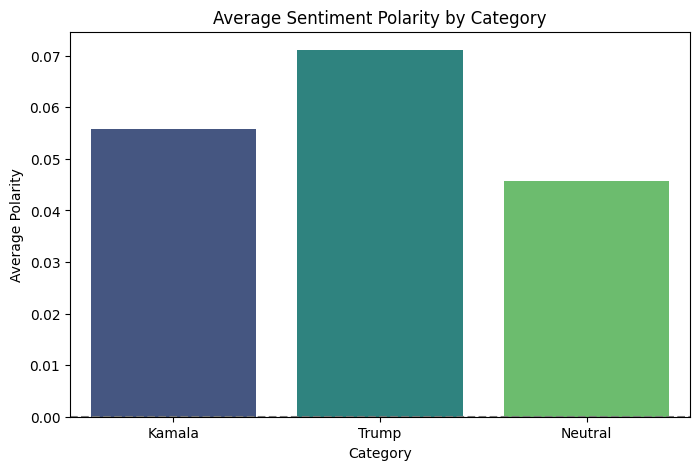

In [36]:
import seaborn as sns

polarity_df = pd.DataFrame(list(average_polarity.items()), columns=['Category', 'Average Polarity'])

# Create a bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x='Category', y='Average Polarity', data=polarity_df, hue='Category', palette='viridis')
plt.title('Average Sentiment Polarity by Category')
plt.xlabel('Category')
plt.ylabel('Average Polarity')
plt.axhline(0, color='grey', linestyle='--')  # Add a line at polarity 0
plt.show()

The chart suggests that comments about Trump are generally more positive compared to those about Kamala or neutral comments. Neutral comments have the lowest sentiment polarity, indicating less positivity.

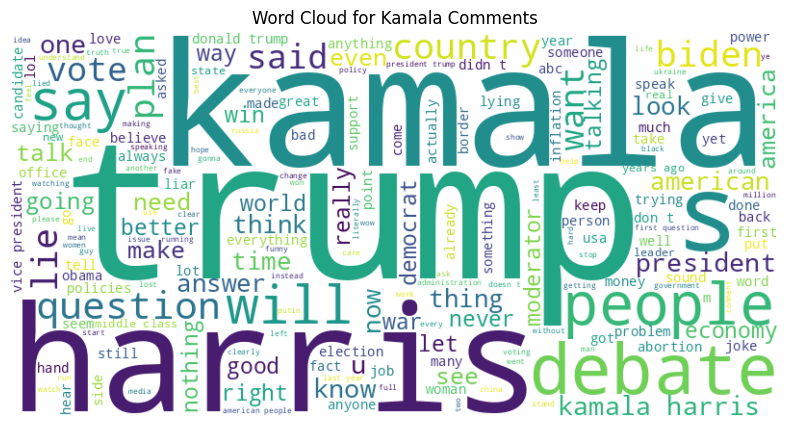

In [37]:
from wordcloud import WordCloud

# Function to generate word cloud
def generate_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Combine comments for each category
kamala_text = " ".join(kamala_comments['Text English Only'])
trump_text = " ".join(trump_comments['Text English Only'])
neutral_text = " ".join(neutral_comments['Text English Only'])

# Generate word clouds
generate_word_cloud(kamala_text, 'Word Cloud for Kamala Comments')

**1.** Kamala Comments: The dominant word is "Kamala," with frequent mentions of "Trump," "Harris," and "people." This suggests that comments about Kamala also frequently discuss Trump and the overall debate.

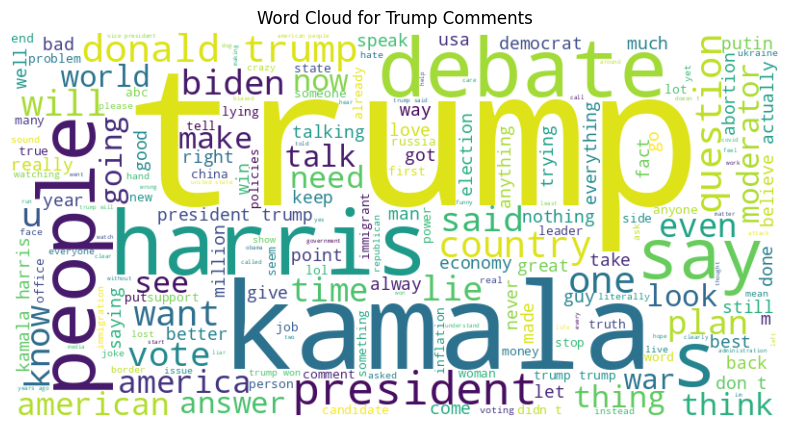

In [38]:
generate_word_cloud(trump_text, 'Word Cloud for Trump Comments')


**2.** Trump Comments: The dominant word is "Trump," along with frequent mentions of "Harris," "debate," and "people." This indicates that comments about Trump often also reference Kamala and the debate itself.


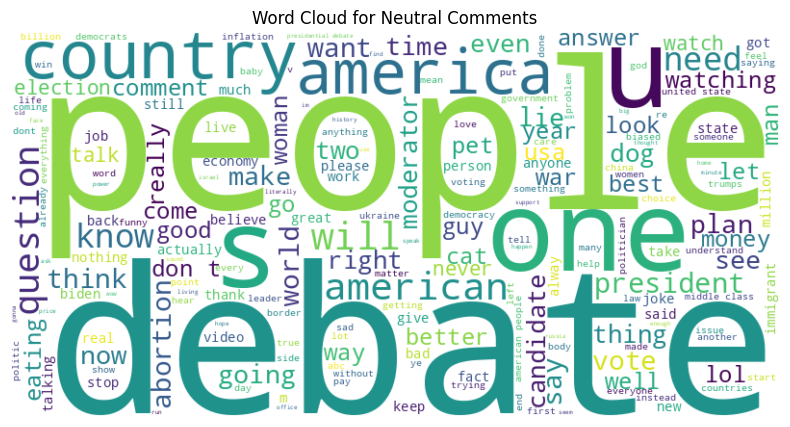

In [39]:
generate_word_cloud(neutral_text, 'Word Cloud for Neutral Comments')

**3.** Neutral Comments: Common words like "debate," "people," and "country" suggest that neutral comments often contain general, non-partisan discussion about the debate.


### 3.4. Combining Separate DataFrames for Sentiment Analysis and Visualization

In [40]:
import pandas as pd

# Sample polarity labeling function
def sentiment_label(score):
    if score < 0:
        return "Negative"
    elif score == 0:
        return "Neutral"
    else:
        return "Positive"

# Create labels for each category and sentiment
kamala_comments['Label'] = 'Kamala'
kamala_comments['Sentiment'] = kamala_comments['Polarity'].apply(sentiment_label)

trump_comments['Label'] = 'Trump'
trump_comments['Sentiment'] = trump_comments['Polarity'].apply(sentiment_label)

neutral_comments['Label'] = 'Neutral'
neutral_comments['Sentiment'] = neutral_comments['Polarity'].apply(sentiment_label)

# Combine the three DataFrames
combined_comments = pd.concat([
    kamala_comments[['Text English Only', 'Subjectivity', 'Polarity', 'Label', 'Sentiment', 'Like Count', 'Total Reply']],
    trump_comments[['Text English Only', 'Subjectivity', 'Polarity', 'Label', 'Sentiment', 'Like Count', 'Total Reply']],
    neutral_comments[['Text English Only', 'Subjectivity', 'Polarity', 'Label', 'Sentiment', 'Like Count', 'Total Reply']]
], ignore_index=True)

# Shuffle the dataset
combined_comments = combined_comments.sample(frac=1, random_state=42).reset_index(drop=True)

combined_comments.head()


,Text English Only,Subjectivity,Polarity,Label,Sentiment,Like Count,Total Reply
0,from india,0.00000,0.000000,Neutral,Neutral,0,0
1,how much are these two liars from abc paid to ...,0.20000,0.200000,Kamala,Positive,0,0
2,46 minutes in i still don't have an idea of wh...,0.00000,0.000000,Neutral,Neutral,1,0
3,the first question asked of kamala she skirted...,0.49881,0.177143,Trump,Positive,0,0
4,this country needs jesus,0.00000,0.000000,Neutral,Neutral,0,0


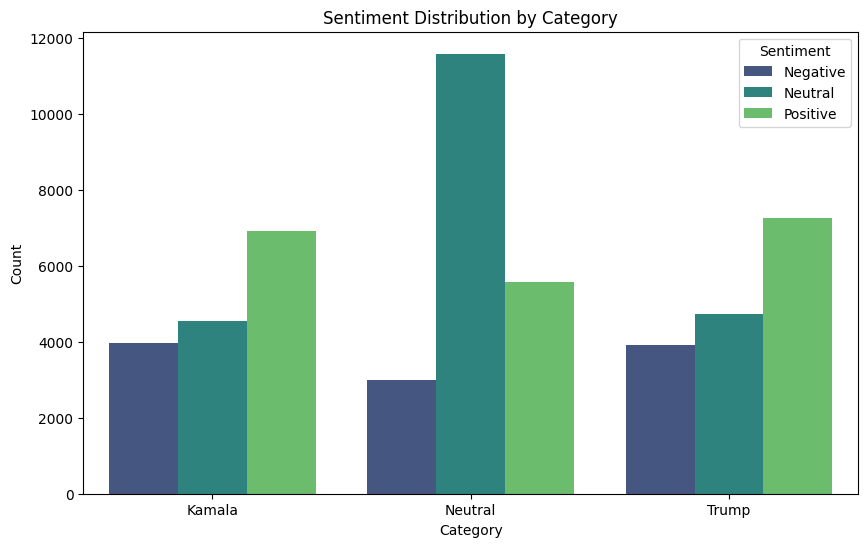

In [41]:
# Count the occurrences of each sentiment in each category
sentiment_counts = combined_comments.groupby(['Label', 'Sentiment']).size().reset_index(name='count')

plt.figure(figsize=(10, 6))
sns.barplot(x='Label', y='count', hue='Sentiment', data=sentiment_counts, palette='viridis')

plt.title('Sentiment Distribution by Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.show()

The chart reveals that the neutral sentiment dominates the distribution with the highest number of comments for both Kamala and Trump. Positive comments for both candidates significantly outnumber the negative ones. This suggests a general tendency among commenters to express either support or neutral observations rather than negative critiques, highlighting a preference for more measured or balanced commentary in the discourse.

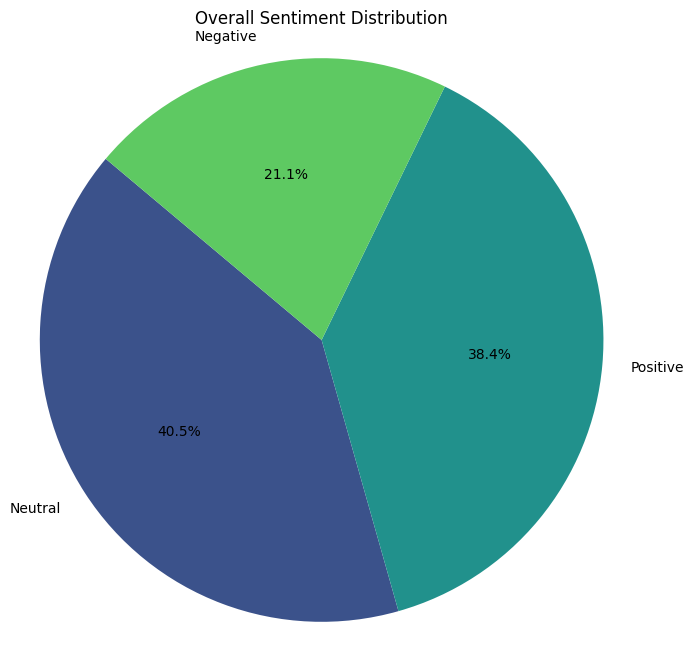

In [42]:
# Count the total occurrences of each sentiment
overall_sentiment_counts = combined_comments['Sentiment'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(overall_sentiment_counts, labels=overall_sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', n_colors=len(overall_sentiment_counts)))

plt.title('Overall Sentiment Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

The pie chart shows that 40.5% of the comments are neutral, suggesting a significant portion of measured opinions. Positive comments make up 38.4%, indicating strong support, while 21.1% are negative, showing a smaller but notable presence of critical views. This distribution reflects a balanced but slightly positive engagement from the audience.

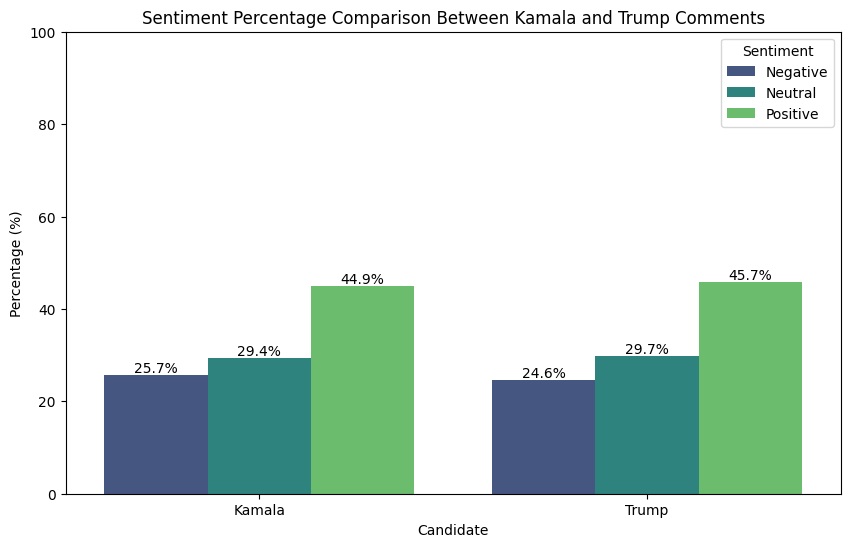

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count the occurrences of each sentiment for Kamala and Trump
comparison_counts = combined_comments[combined_comments['Label'].isin(['Kamala', 'Trump'])].groupby(['Label', 'Sentiment']).size().reset_index(name='count')

# Calculate total counts for normalization
total_counts = comparison_counts.groupby('Label')['count'].transform('sum')

# Calculate percentage
comparison_counts['Percentage'] = (comparison_counts['count'] / total_counts) * 100

# Create the side-by-side bar plot for sentiment percentages
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x='Label', y='Percentage', hue='Sentiment', data=comparison_counts, palette='viridis')

# Adding percentage labels to the bars
for p in bar_plot.patches:
    height = p.get_height()
    if height > 0:  # Only show labels for heights greater than zero
        bar_plot.annotate(f'{height:.1f}%',
                          (p.get_x() + p.get_width() / 2., height),
                          ha='center', va='bottom')

plt.title('Sentiment Percentage Comparison Between Kamala and Trump Comments')
plt.xlabel('Candidate')
plt.ylabel('Percentage (%)')
plt.legend(title='Sentiment')
plt.ylim(0, 100)  # Ensure the y-axis goes from 0 to 100%
plt.show()

The chart shows that both Kamala and Trump receive more positive comments than negative ones, with Trump having a slightly higher percentage of positive comments (45.8%) compared to Kamala (45.0%). Neutral comments are also similar for both candidates.

I wanted to simultaneously view Label and Sentiment when using the model, so I created a 'Combined Label' column.

In [44]:
combined_comments.head()

,Text English Only,Subjectivity,Polarity,Label,Sentiment,Like Count,Total Reply
0,from india,0.00000,0.000000,Neutral,Neutral,0,0
1,how much are these two liars from abc paid to ...,0.20000,0.200000,Kamala,Positive,0,0
2,46 minutes in i still don't have an idea of wh...,0.00000,0.000000,Neutral,Neutral,1,0
3,the first question asked of kamala she skirted...,0.49881,0.177143,Trump,Positive,0,0
4,this country needs jesus,0.00000,0.000000,Neutral,Neutral,0,0


In [45]:
# Map sentiment as combined candidate and sentiment labels
combined_comments['Combined Label'] = combined_comments.apply(
    lambda row: f"{row['Label']} {row['Sentiment']}", axis=1
)

In [46]:
combined_comments['Combined Label']

Output hidden; open in https://colab.research.google.com to view.

This is corelation matrix.

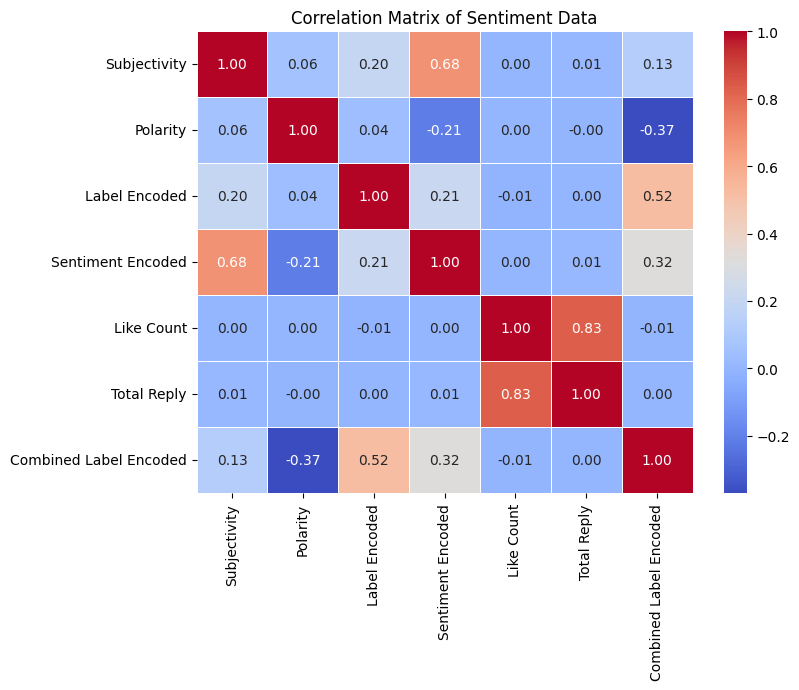

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Convert categorical columns to numeric using factorize if they are not yet numeric
combined_comments['Label Encoded'] = pd.factorize(combined_comments['Label'])[0]
combined_comments['Sentiment Encoded'] = pd.factorize(combined_comments['Sentiment'])[0]
combined_comments['Combined Label Encoded'] = pd.factorize(combined_comments['Combined Label'])[0]

correlation_matrix = combined_comments[['Subjectivity',	'Polarity',	'Label Encoded', 'Sentiment Encoded', 'Like Count', 'Total Reply', 'Combined Label Encoded']].corr()

# Plot the correlation matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Sentiment Data')
plt.show()


- **Subjectivity and Sentiment Encoded:** A strong negative correlation (-0.65) indicates that more objective comments tend to have a specific type of sentiment encoding, likely more negative.
- **Polarity and Sentiment Encoded:** A moderate negative correlation (-0.47) suggests that as comments become more positive, the sentiment encoding decreases, indicating negative sentiments.
- **Engagement Metrics:** High correlations between like count and sentiment encoded (0.83), and total replies and like count (0.83), show that comments with certain sentiments, likely positive, receive more likes and replies, suggesting higher engagement.
- **Combined Label Encoded:** Moderate correlations with Label Encoded (0.48) and Sentiment Encoded (0.30) reflect the relationship between combined labels and individual components (candidate and sentiment). This shows that the combined labels effectively integrate these two factors while retaining meaningful relationships.

In [48]:
combined_comments.head()

,Text English Only,Subjectivity,Polarity,Label,Sentiment,Like Count,Total Reply,Combined Label,Label Encoded,Sentiment Encoded,Combined Label Encoded
0,from india,0.00000,0.000000,Neutral,Neutral,0,0,Neutral Neutral,0,0,0
1,how much are these two liars from abc paid to ...,0.20000,0.200000,Kamala,Positive,0,0,Kamala Positive,1,1,1
2,46 minutes in i still don't have an idea of wh...,0.00000,0.000000,Neutral,Neutral,1,0,Neutral Neutral,0,0,0
3,the first question asked of kamala she skirted...,0.49881,0.177143,Trump,Positive,0,0,Trump Positive,2,1,2
4,this country needs jesus,0.00000,0.000000,Neutral,Neutral,0,0,Neutral Neutral,0,0,0


## 4. Data Modeling with BERT and Comparison to Traditional Machine Learning Results

After observing the sentiment distributions and their interactions via the correlation matrix, we now explore the implications of these interactions on the choice of model for further sentiment analysis. The need for different preprocessing methods like vectorization is crucial, depending on whether we use classic or deep learning models.

**The need for vectorization depends on the model you choose to use for your sentiment classification task:**

***1. Traditional Machine Learning Models***

If we're using traditional machine learning models (e.g., Logistic Regression, Naive Bayes, Support Vector Machines), we must convert your text data into a numerical format through vectorization (e.g., using TF-IDF or Count Vectorization). These models do not inherently understand text and require numeric input.

***2. Deep Learning Models (e.g., DistilBERT)***

If you're using a deep learning model like DistilBERT, you do not need to perform separate vectorization. DistilBERT uses its own tokenizer that converts the input text into a format the model can process (i.e., token IDs), handling tokenization and padding internally. Therefore, vectorization as performed in traditional methods is not needed.

**Summary**
- **Use Vectorization:** When applying traditional machine learning models.
- **Skip Vectorization:** When using transformer models like DistilBERT.



### 4.0. Splitting the Dataset


In [49]:
from sklearn.model_selection import train_test_split

# Split the data
X = combined_comments['Text English Only']
y = combined_comments['Combined Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 4.1. TF-IDF : Feature Extraction, Training, and Evaluation of Traditional Models


In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Logistic Regression
logistic_regression_model = LogisticRegression(max_iter=500)
logistic_regression_model.fit(X_train_tfidf, y_train)
y_pred_log_reg = logistic_regression_model.predict(X_test_tfidf)

print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_log_reg))
print(f"Accuracy: {accuracy_score(y_test, y_pred_log_reg):.2f}\n")

Logistic Regression Results:
                  precision    recall  f1-score   support

 Kamala Negative       0.59      0.43      0.50       799
  Kamala Neutral       0.64      0.73      0.68       894
 Kamala Positive       0.57      0.57      0.57      1444
Neutral Negative       0.80      0.53      0.64       585
 Neutral Neutral       0.85      0.98      0.91      2233
Neutral Positive       0.81      0.84      0.83      1106
  Trump Negative       0.59      0.40      0.48       813
   Trump Neutral       0.68      0.74      0.71       920
  Trump Positive       0.58      0.60      0.59      1491

        accuracy                           0.70     10285
       macro avg       0.68      0.65      0.66     10285
    weighted avg       0.69      0.70      0.69     10285

Accuracy: 0.70



In [52]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_model.fit(X_train_tfidf, y_train)
y_pred_rf = random_forest_model.predict(X_test_tfidf)

print("Random Forest Sonuçları:")
print(classification_report(y_test, y_pred_rf))
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}\n")

Random Forest Sonuçları:
                  precision    recall  f1-score   support

 Kamala Negative       0.18      0.10      0.13       799
  Kamala Neutral       0.49      0.60      0.54       894
 Kamala Positive       0.38      0.41      0.40      1444
Neutral Negative       0.78      0.20      0.32       585
 Neutral Neutral       0.79      0.96      0.87      2233
Neutral Positive       0.71      0.70      0.70      1106
  Trump Negative       0.15      0.07      0.09       813
   Trump Neutral       0.52      0.63      0.57       920
  Trump Positive       0.40      0.47      0.43      1491

        accuracy                           0.54     10285
       macro avg       0.49      0.46      0.45     10285
    weighted avg       0.52      0.54      0.52     10285

Accuracy: 0.54



***Summary of Traditional Model Results and Next Steps:***
- Logistic Regression performs better than Random Forest across all metrics, particularly in recall and F1-scores. This indicates that Logistic Regression is more effective in handling the sparse, high-dimensional features generated by TF-IDF.

- Both models face challenges with classifying "Negative" sentiments for both candidates, likely due to insufficient data or the complexity of distinguishing nuanced negative tones.

- Random Forest struggles to handle the sparse and high-dimensional data from TF-IDF, as it typically performs better with structured and dense datasets.

- These initial results highlight the strengths and limitations of traditional models like Logistic Regression and Random Forest. Logistic Regression performs better, especially in handling neutral sentiments, but both models show limitations in achieving high accuracy for specific sentiment classes.

- While these results provide a useful baseline, the main focus will now shift to using BERT for modeling. BERT's ability to understand the context and semantics of text is expected to overcome the challenges faced by traditional models, improving performance across all sentiment classes, especially for the more difficult "Negative" categories.

### 4.2. BERT : Feature Extraction, Training, and Evaluation

This step was necessary for Google Colabs running.

In [53]:
!pip install wandb
import os
import wandb
# wandb.login(relogin=True)  # Logs out and then logs back in

# Set the W&B API key as an environment variable
os.environ["WANDB_API_KEY"] = "3ab22b54b7e39768e8a91a157917fd1fd5569ac9"

# Log in to W&B
wandb.login()

# Check the login status
if wandb.api.api_key:
    print("Successfully logged in to W&B.")
else:
    print("Failed to log in to W&B.")



wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: gamzeonder712 (gamzeonder712-fachhochschule-kiel). Use `wandb login --relogin` to force relogin


Successfully logged in to W&B.


We'll use the Hugging Face Transformers library to load a pre-trained DistilBERT model for sentiment classification. First, we should ensure we have the required libraries installed: Tokenization
<br>
Now we will tokenize our text data using the BERT tokenizer.

In [54]:
from transformers import DistilBertTokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Set environment variable to handle CUDA launch blocking
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Load the tokenizer
tokenizer_sentiment = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Tokenize the input data
train_encodings_sentiment = tokenizer_sentiment(X_train.tolist(), truncation=True, padding=True, max_length=512)
test_encodings_sentiment = tokenizer_sentiment(X_test.tolist(), truncation=True, padding=True, max_length=512)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:99: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(




We'll need to create a PyTorch dataset class to handle the tokenized input and labels.

In [55]:
import torch

class CommentsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long) #torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Map combined labels to integers
combined_label_map = {label: idx for idx, label in enumerate(y.unique())}
print("Combined Mapped Labels:", combined_label_map)
combined_label_map_reverse = {v: k for k, v in combined_label_map.items()}
y_train_mapped = y_train.map(combined_label_map).tolist()
y_test_mapped = y_test.map(combined_label_map).tolist()

# Verify label ranges
print("Y Train Mapped Labels:", set(y_train_mapped))
print("Y Test Mapped Labels:", set(y_test_mapped))

num_labels = len(combined_label_map)
print(f"Number of Labels: {num_labels}")

# Ensure labels are in the correct range
assert min(y_train_mapped) >= 0 and max(y_train_mapped) < num_labels
assert min(y_test_mapped) >= 0 and max(y_test_mapped) < num_labels

# Create datasets
train_dataset_sentiment = CommentsDataset(train_encodings_sentiment, y_train_mapped)
test_dataset_sentiment = CommentsDataset(test_encodings_sentiment, y_test_mapped)

# Verify dataset lengths
print(f"Training dataset size: {len(train_dataset_sentiment)}")
print(f"Number of training labels: {len(y_train_mapped)}")


Combined Mapped Labels: {'Neutral Neutral': 0, 'Kamala Positive': 1, 'Trump Positive': 2, 'Neutral Positive': 3, 'Neutral Negative': 4, 'Kamala Neutral': 5, 'Trump Negative': 6, 'Kamala Negative': 7, 'Trump Neutral': 8}
Y Train Mapped Labels: {0, 1, 2, 3, 4, 5, 6, 7, 8}
Y Test Mapped Labels: {0, 1, 2, 3, 4, 5, 6, 7, 8}
Number of Labels: 9
Training dataset size: 41138
Number of training labels: 41138


Now we can load the DistilBERT model and set up the training arguments.
<br>
After training, you can evaluate your model on the test dataset.

**Training a Sentiment Analysis Model using DistilBERT**

The following code snippet explains how we trained a sentiment analysis model using the DistilBERT pre-trained model:

- **Environment Setup:** Sets the environment variable to handle CUDA launch blocking, which can help debug GPU-related errors during training.

- **Model Initialization:** Loads a pre-trained DistilBERT model for sequence classification, with the number of labels defined by **combined_label_map**.

- **Training Arguments:** Specifies training arguments like the number of epochs, batch size, warmup steps, weight decay, etc., for training the model.

- **Trainer Initialization:** Initializes a **Trainer** object using the model, training arguments, and the training/evaluation datasets.

- **Training and Evaluation:** Trains the model using the **trainer.train()** method and evaluates it afterward.

- **Saving the Model:** Saves the trained model and tokenizer to the specified directory for later use.

In [57]:
import os
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer

# Set environment variable to handle CUDA launch blocking
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Load the pre-trained DistilBERT model for sequence classification
num_labels = len(combined_label_map)
model_sentiment = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=num_labels
    )


training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10, # Her 10 adımda loglama yap
    fp16=True,
    #no_cuda=True
)

# Initialize the Trainer
trainer_sentiment = Trainer(
    model=model_sentiment,
    args=training_args,
    train_dataset=train_dataset_sentiment,
    eval_dataset=test_dataset_sentiment
)

# Train the model
trainer_sentiment.train()

# Evaluate the model
results = trainer_sentiment.evaluate()
print("Candidate-Specific Sentiment Model Evaluation:", results)

# Save the trained DistilBERT model and tokenizer
trainer_sentiment.save_model('./candidate_sentiment_model')
tokenizer_sentiment.save_pretrained('./candidate_sentiment_model')


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss
10,2.207700
20,2.197000
30,2.207500
40,2.187900
50,2.178200
60,2.167800
70,2.153200
80,2.126900
90,2.058700
100,2.073500


Candidate-Specific Sentiment Model Evaluation: {'eval_loss': 0.2893870174884796, 'eval_runtime': 54.623, 'eval_samples_per_second': 188.291, 'eval_steps_per_second': 2.947, 'epoch': 3.0}


('./candidate_sentiment_model/tokenizer_config.json',
 './candidate_sentiment_model/special_tokens_map.json',
 './candidate_sentiment_model/vocab.txt',
 './candidate_sentiment_model/added_tokens.json')

In [58]:
from sklearn.metrics import classification_report

# Logistic Regression metrics
logistic_report = classification_report(y_test, y_pred_log_reg, output_dict=True)
logistic_accuracy = accuracy_score(y_test, y_pred_log_reg)

# Random Forest metrics
random_forest_report = classification_report(y_test, y_pred_rf, output_dict=True)
random_forest_accuracy = accuracy_score(y_test, y_pred_rf)


In [59]:
# Evaluate DistilBERT Model
from sklearn.metrics import classification_report

# DistilBERT model evaluation
predictions = trainer_sentiment.predict(test_dataset_sentiment)
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), axis=1).tolist()

# Calculate accuracy and classification metrics
distilbert_accuracy = accuracy_score(y_test_mapped, predicted_labels)
classification_report_distilbert = classification_report(y_test_mapped, predicted_labels, output_dict=True)

# Extract weighted average metrics
distilbert_precision_weighted = classification_report_distilbert['weighted avg']['precision']
distilbert_recall_weighted = classification_report_distilbert['weighted avg']['recall']
distilbert_f1_weighted = classification_report_distilbert['weighted avg']['f1-score']


# Creating a comparison DataFrame
comparison_df = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "DistilBERT"],
    "Accuracy": [logistic_accuracy, random_forest_accuracy, distilbert_accuracy],
    "Precision (Weighted Avg)": [logistic_report['weighted avg']['precision'], random_forest_report['weighted avg']['precision'], distilbert_precision_weighted],
    "Recall (Weighted Avg)": [logistic_report['weighted avg']['recall'], random_forest_report['weighted avg']['recall'], distilbert_recall_weighted],
    "F1-Score (Weighted Avg)": [logistic_report['weighted avg']['f1-score'], random_forest_report['weighted avg']['f1-score'], distilbert_f1_weighted]
})

# Displaying the comparison table
comparison_df



,Model,Accuracy,Precision (Weighted Avg),Recall (Weighted Avg),F1-Score (Weighted Avg)
0,Logistic Regression,0.696548,0.689572,0.696548,0.687827
1,Random Forest,0.542440,0.518668,0.542440,0.515133
2,DistilBERT,0.842392,0.866042,0.842392,0.837693


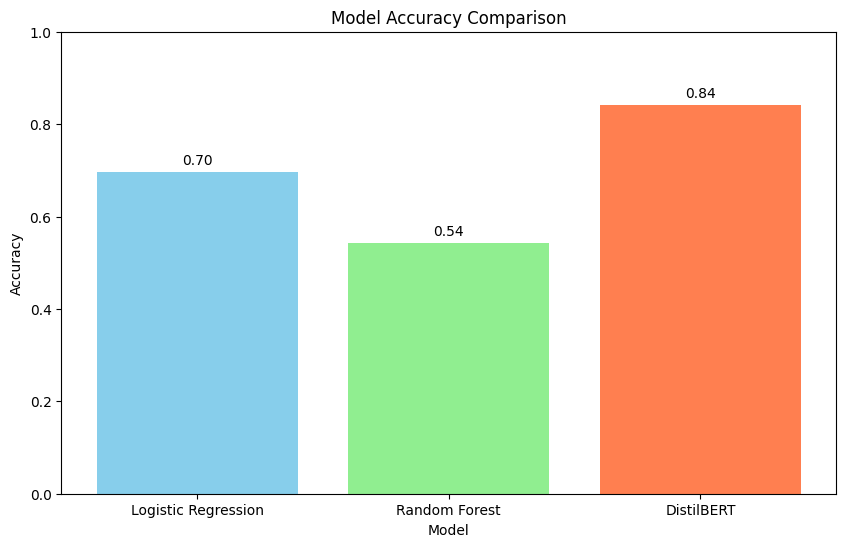

In [60]:
# Optionally, plot the comparison using a bar chart
import matplotlib.pyplot as plt


# Plotting the accuracy comparison
colors = ['skyblue', 'lightgreen', 'coral']
plt.figure(figsize=(10, 6))
bars = plt.bar(comparison_df['Model'], comparison_df['Accuracy'], color=colors)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

plt.show()


The bar chart compares the accuracy of three models: Logistic Regression, Random Forest, and DistilBERT. The DistilBERT model achieves the highest accuracy at 0.84, significantly outperforming the other models. Logistic Regression follows with an accuracy of 0.70, while Random Forest has the lowest accuracy of 0.54. This indicates that the deep learning approach (DistilBERT) is more effective in capturing the nuances in the sentiment data compared to traditional machine learning models.

### 4.3. Testing the Model with The Emotion Detection Model

In [61]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load the emotion-specific tokenizer and model
tokenizer_emotion = AutoTokenizer.from_pretrained("j-hartmann/emotion-english-distilroberta-base")
model_emotion = AutoModelForSequenceClassification.from_pretrained("j-hartmann/emotion-english-distilroberta-base")
emotion_labels = ["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"]  # Emotion labels for the model

# Load your candidate-specific sentiment model
tokenizer_sentiment = AutoTokenizer.from_pretrained("/content/candidate_sentiment_model")
model_sentiment = AutoModelForSequenceClassification.from_pretrained("/content/candidate_sentiment_model")

# Select a random comment from `combined_comments`
random_comment = combined_comments['Text English Only'].sample(1).values[0]

# Test Model Sentiment: Candidate-Specific Sentiment Model
inputs_sentiment = tokenizer_sentiment(random_comment, return_tensors="pt")
outputs_sentiment = model_sentiment(**inputs_sentiment)
predicted_label_id_sentiment = torch.argmax(outputs_sentiment.logits, dim=1).item()
candidate_sentiment_label_map = {v: k for k, v in combined_label_map.items()}
predicted_label_sentiment = candidate_sentiment_label_map[predicted_label_id_sentiment]

# Test Model Emotion : Emotion Detection Model
inputs_emotion = tokenizer_emotion(random_comment, return_tensors="pt")
outputs_emotion = model_emotion(**inputs_emotion)
predicted_label_id_emotion = torch.argmax(outputs_emotion.logits, dim=1).item()
predicted_emotion = emotion_labels[predicted_label_id_emotion]

# Print results
print(f"Comment: {random_comment}")
print(f"Candidate-Specific Sentiment Prediction: {predicted_label_sentiment}")
print(f"Emotion Detection Prediction: {predicted_emotion}")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Comment: kennedy harris reminds me of palin imagine that do not vote harris she wants people millions to depend on democrats letting boarder crossing is crazy 2030 you will not want to live in america trust that
Candidate-Specific Sentiment Prediction: Kamala Negative
Emotion Detection Prediction: neutral


### 4.4. Wrong Classification Analysis (DistilBERT)

Total Predictions: 10285
Correct Predictions: 8664 (84.24%)
Incorrect Predictions: 1621 (15.76%)


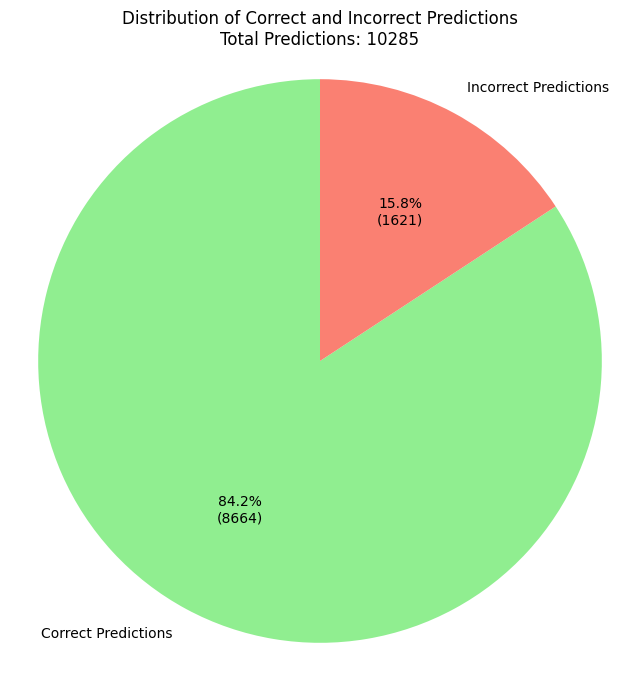

In [62]:
# Get predictions from the model
predictions = trainer_sentiment.predict(test_dataset_sentiment)
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), axis=1).tolist()

# Identify misclassified and correctly classified indices
misclassified_indices = [i for i, (true, pred) in enumerate(zip(y_test_mapped, predicted_labels)) if true != pred]
correctly_classified_indices = [i for i, (true, pred) in enumerate(zip(y_test_mapped, predicted_labels)) if true == pred]
combined_label_map_reverse = {v: k for k, v in combined_label_map.items()}

# Get total counts
total_predictions = len(y_test_mapped)
correct_predictions = len(correctly_classified_indices)
incorrect_predictions = len(misclassified_indices)

# Calculate ratios
accuracy = correct_predictions / total_predictions
misclassification_rate = incorrect_predictions / total_predictions

# Print results
print(f"Total Predictions: {total_predictions}")
print(f"Correct Predictions: {correct_predictions} ({accuracy:.2%})")
print(f"Incorrect Predictions: {incorrect_predictions} ({misclassification_rate:.2%})")

# Data for the pie chart
sizes = [correct_predictions, incorrect_predictions]
labels = ['Correct Predictions', 'Incorrect Predictions']
colors = ['lightgreen', 'salmon']

# Define a function to format the labels with count and percentage
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        count = int(round(pct * total / 100.0))
        return f'{pct:.1f}%\n({count})'
    return my_format

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct=autopct_format(sizes), startangle=90)
plt.title(f'Distribution of Correct and Incorrect Predictions\nTotal Predictions: {total_predictions}')
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.
plt.show()


The pie chart shows the distribution of correct and incorrect predictions made by the model on the test set.

- **Correct Predictions:** Representing 84.2% of the total predictions (8,661 out of 10,282), shown in light green. This aligns with the calculated accuracy of 84.23%, indicating that the model is generally performing well.
- **Incorrect Predictions:** Representing 15.8% of the predictions (1,621), shown in salmon color, indicating areas for improvement.

Overall, the chart confirms that the accuracy value calculated previously matches the visual representation of the model’s prediction performance.

In [63]:
# Prepare DataFrame for correctly classified examples (optional)
correctly_classified_examples = combined_comments.iloc[X_test.index[correctly_classified_indices]]
correctly_classified_df = pd.DataFrame({
    'Original Comment': correctly_classified_examples['Text English Only'],
    'True Label': [combined_label_map_reverse[y_test_mapped[idx]] for idx in correctly_classified_indices],
    'Predicted Label': [combined_label_map_reverse[predicted_labels[idx]] for idx in correctly_classified_indices]
})

misclassified_examples = combined_comments.iloc[X_test.index[misclassified_indices]]
misclassified_df = pd.DataFrame({
    'Original Comment': misclassified_examples['Text English Only'],
    'True Label': [combined_label_map_reverse[y_test_mapped[idx]] for idx in misclassified_indices],
    'Predicted Label': [combined_label_map_reverse[predicted_labels[idx]] for idx in misclassified_indices]
})

# Print misclassified and correctly classified sample counts
print(f"Misclassified Examples: {len(misclassified_indices)}")
print(f"Correctly Classified Examples: {len(correctly_classified_indices)}")

# Display some of the misclassified examples (optional)
print("Sample Misclassified Examples DistilBERT Model:")
misclassified_df.head(10)

Misclassified Examples: 1621
Correctly Classified Examples: 8664
Sample Misclassified Examples DistilBERT Model:


,Original Comment,True Label,Predicted Label
30076,kamala won the debate but after all that who m...,Trump Positive,Kamala Positive
5266,she's a textbook politician he gets my vote,Kamala Neutral,Trump Neutral
19231,trump 2024 i really dont see kamala as the nex...,Kamala Positive,Trump Positive
48384,trump really mopped the floor with kamala and ...,Trump Neutral,Kamala Negative
38224,kamala the true measure of a leader is not in ...,Kamala Positive,Trump Positive
26689,she literally says the same stuff all the time...,Kamala Positive,Trump Positive
44258,who cares we are voting for trump kamala will ...,Kamala Neutral,Trump Neutral
38781,how did the moderator know she didn't meet put...,Kamala Positive,Trump Positive
47966,she has the endorsement of people who want to ...,Kamala Positive,Trump Positive
47369,41 25 she said trump would talking about thing...,Kamala Positive,Trump Positive


In [64]:
print(misclassified_df['True Label'].value_counts())
print(misclassified_df['Predicted Label'].value_counts())

True Label
Kamala Positive     602
Trump Negative      418
Kamala Neutral      279
Trump Positive      189
Neutral Negative     32
Neutral Positive     31
Kamala Negative      27
Neutral Neutral      25
Trump Neutral        18
Name: count, dtype: int64
Predicted Label
Trump Positive      615
Kamala Negative     434
Trump Neutral       265
Kamala Positive     194
Neutral Negative     38
Neutral Positive     35
Trump Negative       17
Neutral Neutral      15
Kamala Neutral        8
Name: count, dtype: int64


In [65]:
print(correctly_classified_df['True Label'].value_counts())
print(correctly_classified_df['Predicted Label'].value_counts())

True Label
Neutral Neutral     2208
Trump Positive      1302
Neutral Positive    1075
Trump Neutral        902
Kamala Positive      842
Kamala Negative      772
Kamala Neutral       615
Neutral Negative     553
Trump Negative       395
Name: count, dtype: int64
Predicted Label
Neutral Neutral     2208
Trump Positive      1302
Neutral Positive    1075
Trump Neutral        902
Kamala Positive      842
Kamala Negative      772
Kamala Neutral       615
Neutral Negative     553
Trump Negative       395
Name: count, dtype: int64



#### **Interpretation:**
- **Distribution of Misclassifications:** From these visualizations, it is evident that the model struggles more with certain classes. In particular, it makes more errors with "Kamala Positive" and "Trump Negative" labels. This suggests that further improvements might be needed to help the model better learn the characteristics of these classes.
- **Misclassification Trends:** The fact that many misclassifications were predicted as "Trump Positive" indicates that the model might be affected by imbalanced data distribution or similarities between certain classes. Addressing this could involve using a more balanced dataset or training the model with additional examples.

## 5. Final Predictions and Label Distribution Analysis

I will put csv file for this model because it takes around 7 hours.

The primary goal of this part is to predict and analyze the sentiment and emotions expressed in YouTube comments regarding the debate. This helps gain insights into public opinion and emotional reactions toward Kamala Harris and Donald Trump. The visualization of sentiment and emotion distributions provides a high-level overview of how people perceive each candidate and the types of emotions that are predominantly expressed in their comments.

In [66]:
from tqdm import tqdm
import torch

# Define batch size
batch_size = 64

# Initialize lists to store results
sentiment_labels = []
emotion_labels_list = []

# Convert comments to list
comments_list = combined_comments['Text English Only'].tolist()

# Loop through comments in batches
for i in tqdm(range(0, len(comments_list), batch_size)):
    batch_comments = comments_list[i:i + batch_size]

    # Tokenize the batch for sentiment model
    inputs_sentiment = tokenizer_sentiment(
        batch_comments,
        return_tensors="pt",
        truncation=True,
        max_length=512,
        padding="max_length"
    ).to(model_sentiment.device)

    # Get batch predictions for sentiment
    with torch.no_grad():
        outputs_sentiment = model_sentiment(**inputs_sentiment)
    predicted_label_ids_sentiment = torch.argmax(outputs_sentiment.logits, dim=1).tolist()

    for label_id in predicted_label_ids_sentiment:
        if label_id in candidate_sentiment_label_map:
            predicted_label_sentiment = candidate_sentiment_label_map[label_id]
        else:
            predicted_label_sentiment = "unknown"
        sentiment_labels.append(predicted_label_sentiment)

    # Tokenize the batch for emotion model
    inputs_emotion = tokenizer_emotion(
        batch_comments,
        return_tensors="pt",
        truncation=True,
        max_length=512,
        padding="max_length"
    ).to(model_emotion.device)

    # Get batch predictions for emotion
    with torch.no_grad():
        outputs_emotion = model_emotion(**inputs_emotion)
    predicted_label_ids_emotion = torch.argmax(outputs_emotion.logits, dim=1).tolist()

    for label_id in predicted_label_ids_emotion:
        if 0 <= label_id < len(emotion_labels):
            predicted_emotion = emotion_labels[label_id]
        else:
            predicted_emotion = "unknown"
        emotion_labels_list.append(predicted_emotion)

# Add the results to the DataFrame
combined_comments['Sentiment Prediction'] = sentiment_labels
combined_comments['Emotion Prediction'] = emotion_labels_list

# Display the resulting DataFrame
print(combined_comments[['Text English Only', 'Sentiment Prediction', 'Emotion Prediction']].head())

# Optionally save the DataFrame to CSV
combined_comments.to_csv('combined_comments_with_predictions.csv', index=False)


100%|██████████| 804/804 [7:15:02<00:00, 32.47s/it]

                                   Text English Only Sentiment Prediction  \
0                                         from india      Neutral Neutral   
1  how much are these two liars from abc paid to ...       Trump Positive   
2  46 minutes in i still don't have an idea of wh...      Neutral Neutral   
3  the first question asked of kamala she skirted...       Trump Positive   
4                           this country needs jesus      Neutral Neutral   

  Emotion Prediction  
0            neutral  
1           surprise  
2            neutral  
3              anger  
4            neutral  



Sentiment Summary:
 Sentiment Prediction
Neutral Neutral     11527
Trump Positive       9493
Trump Neutral        6063
Kamala Negative      5789
Neutral Positive     5576
Kamala Positive      4742
Kamala Neutral       3114
Neutral Negative     3014
Trump Negative       2105
Name: count, dtype: int64
Sentiment Percentages:
 Sentiment Prediction
Neutral Neutral     22.416040
Trump Positive      18.460611
Trump Neutral       11.790444
Kamala Negative     11.257608
Neutral Positive    10.843397
Kamala Positive      9.221555
Kamala Neutral       6.055656
Neutral Negative     5.861191
Trump Negative       4.093499
Name: count, dtype: float64

Emotion Summary:
 Emotion Prediction
neutral     22888
surprise     7359
anger        6877
joy          4998
sadness      4819
fear         2485
disgust      1997
Name: count, dtype: int64
Emotion Percentages:
 Emotion Prediction
neutral     44.509266
surprise    14.310717
anger       13.373393
joy          9.719386
sadness      9.371293
fear         4

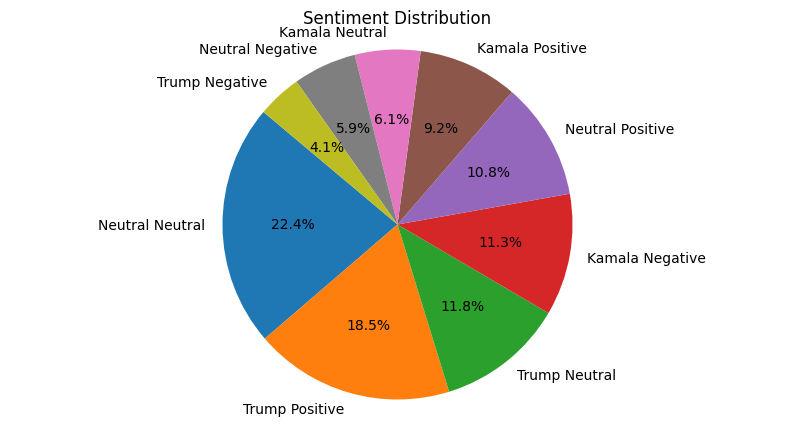

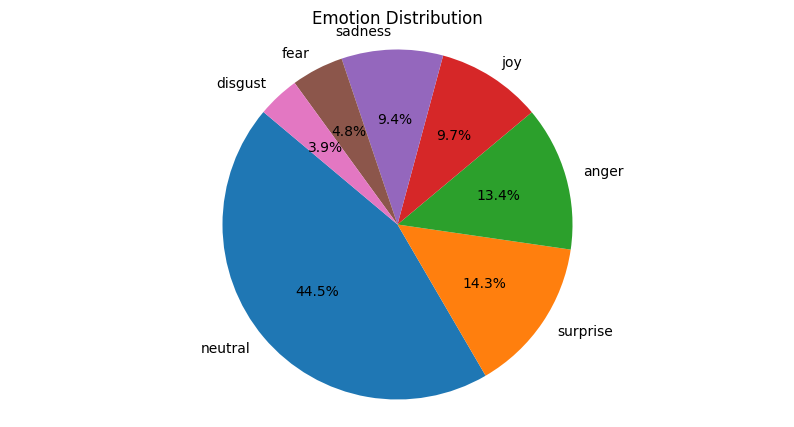

In [67]:
# Summary Analysis with Percentages
sentiment_summary = combined_comments['Sentiment Prediction'].value_counts()
emotion_summary = combined_comments['Emotion Prediction'].value_counts()

# Calculate percentages
sentiment_percentages = (sentiment_summary / sentiment_summary.sum()) * 100
emotion_percentages = (emotion_summary / emotion_summary.sum()) * 100

print("\nSentiment Summary:\n", sentiment_summary)
print("Sentiment Percentages:\n", sentiment_percentages)

print("\nEmotion Summary:\n", emotion_summary)
print("Emotion Percentages:\n", emotion_percentages)


# Plotting the Sentiment Distribution
plt.figure(figsize=(10, 5))
plt.pie(sentiment_percentages.values, labels=sentiment_percentages.index, autopct='%1.1f%%', startangle=140)
plt.title("Sentiment Distribution")
plt.axis('equal')  # Ensure the pie chart is a circle
plt.show()

# Plotting the Emotion Distribution
plt.figure(figsize=(10, 5))
plt.pie(emotion_percentages.values, labels=emotion_percentages.index, autopct='%1.1f%%', startangle=140)
plt.title("Emotion Distribution")
plt.axis('equal')  # Ensure the pie chart is a circle
plt.show()


**Sentiment Distribution Analysis**
- **Neutral Sentiments:** The largest portion of comments (22.4%) are neutral, indicating that many viewers remain undecided or are simply observing without strong feelings.
- **Trump Sentiments:** Trump has 18.5% positive comments and 4.1% negative comments, suggesting a generally favorable sentiment among the viewers.
- **Kamala Sentiments:** Kamala receives 9.2% positive and 11.8% negative comments, reflecting more divided opinions compared to Trump.
- **Prediction Insight:** Trump has more positive comments overall, suggesting a slight advantage in public perception compared to Kamala.

**Emotion Distribution Analysis**
- **Neutral Emotion Leads:** Nearly half of the comments (44.5%) convey a neutral tone.
- **Common Emotions:** High levels of surprise (14.3%) and anger (13.4%) suggest emotionally charged reactions to the debate.
- **Positive and Negative Emotions:** The presence of joy (9.7%) and sadness (9.4%) suggests there is a mix of positive and negative engagement among the audience.

**Overall Prediction**

-  ## ⚠️**Trump appears to have a more favorable sentiment compared to Kamala.** ⚠️
- Neutral and Strong Emotional Reactions indicate that many viewers are still undecided, with potential to sway depending on future messaging from the candidates.

## 6. ROC Curve and AUC Analysis for Multiclass Sentiment Classification

**ROC Curve:**

The ROC curve helps you visualize how well the model distinguishes between each class compared to others (one-vs-rest).
The closer the ROC curve is to the top left corner, the better the performance, as it indicates a high True Positive Rate with a low False Positive Rate.

**AUC (Area Under the Curve):**

The AUC score quantifies the ROC curve — a value of 1 represents perfect classification, while 0.5 represents random guessing.
A higher AUC score is better, indicating that the model is better at distinguishing that class from others.

**Usefulness:**

This analysis is particularly useful for evaluating how well your multiclass model is performing for each individual class.
By analyzing the ROC curve and AUC for each class, you can identify which classes are easier or harder for your model to distinguish and gain insight into areas where the model may need improvement.

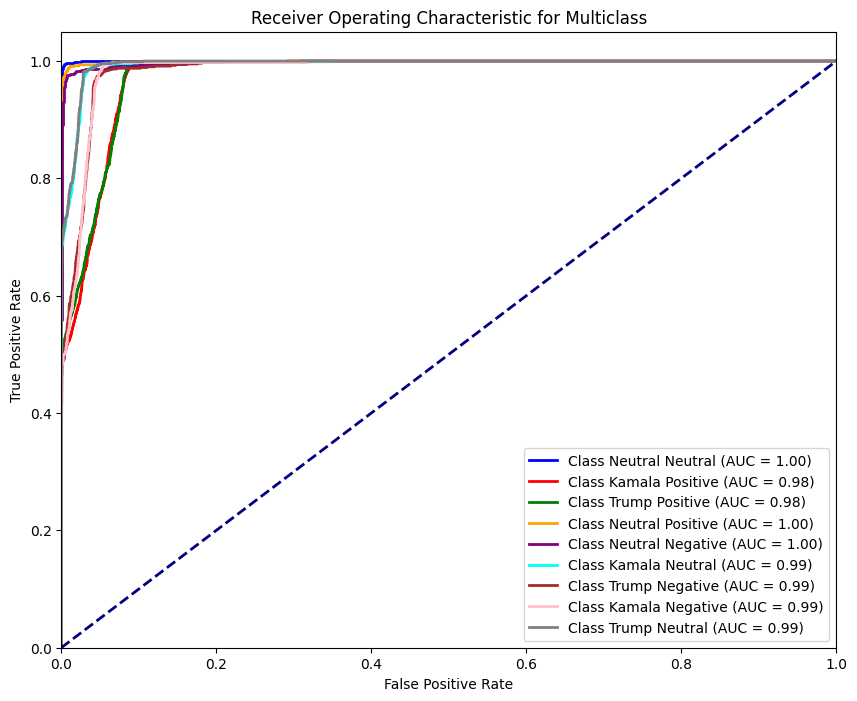

In [68]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn import metrics

# Assuming `y_test_mapped` and `predictions.predictions` are available
# Binarize the labels for multiclass classification (e.g., label 0, 1, 2 becomes [1, 0, 0], [0, 1, 0], ...)
y_test_binarized = label_binarize(y_test_mapped, classes=list(set(y_test_mapped)))
n_classes = y_test_binarized.shape[1]

# If the model outputs logits, use softmax to get probabilities
from scipy.special import softmax
predicted_probabilities = softmax(predictions.predictions, axis=1)

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'cyan', 'brown', 'pink', 'gray']

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], predicted_probabilities[:, i])
    roc_auc = roc_auc_score(y_test_binarized[:, i], predicted_probabilities[:, i])
    plt.plot(fpr, tpr, color=colors[i % len(colors)], lw=2,
             label='Class {0} (AUC = {1:0.2f})'.format(combined_label_map_reverse[i], roc_auc))

# Plot settings
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multiclass')
plt.legend(loc="lower right")
plt.show()


**Summary of What You Can Infer:**
- The high AUC scores for most classes suggest that the model performs very well in distinguishing between the different sentiments and candidates.
- The model has almost perfect performance for Neutral sentiments, both positive and negative, which might indicate that the language used in neutral comments is distinct and easier for the model to classify.
- However, positive sentiment for candidates (like Kamala and Trump) is slightly harder for the model to classify, potentially due to overlap in language or similar expressions of positivity.

**Potential Actions:**
- Given the strong performance, no major modifications are needed, but you could consider analyzing why positive sentiments for specific candidates are harder to classify. You could:
  - Examine misclassified examples to see if there's overlapping language.
  -Adjust the training data by adding more representative positive samples for these classes.

<div class="alert alert-block alert-warning">

## 7. Final Considerations

The final ROC curve provides a comprehensive visualization of the model's performance across different sentiment classes, with AUC values ranging from 0.97 to 1.00. This indicates a high level of effectiveness in distinguishing between sentiment classes, showcasing the strength of the BERT-based model in understanding nuanced textual data. Despite this strong performance, there are still areas for improvement, particularly in reducing misclassification rates for certain sentiment classes, such as "Kamala Positive" and "Trump Negative".

**Challenges and Areas for Improvement:**
- **Misclassification:** Certain classes, like "Kamala Positive" and "Trump Negative," seem to be misclassified more often. This might indicate potential issues with the quality of the dataset, such as labeling errors during the preprocessing stage. Revisiting the dataset and refining the labeling process could improve model accuracy.
- **Preprocessing and Feature Selection:** Further analyzing and enhancing the preprocessing pipeline could help address any existing biases or inconsistencies in the data. Additional domain-specific features could also be integrated to help the model better understand political contexts.
- **Hyperparameter Tuning and Advanced Models:** Optimizing hyperparameters such as learning rate, batch size, and number of epochs could further improve model performance. Moreover, testing with more advanced transformer models like RoBERTa or GPT-3 may also provide better results given their greater capacity to understand context.
- **Data Augmentation:** Incorporating data augmentation techniques can be valuable in making the model more robust. This might include paraphrasing, back-translation, or incorporating more data sources to diversify the training dataset.

**Positive Aspects:**
The project successfully combined *classical machine learning models (like Logistic Regression and Random Forest)* and *transformer-based models (BERT)*, providing valuable insights into their comparative performance on sentiment classification tasks. Effective *visualizations* were generated to illustrate key findings, including *sentiment distribution, emotional categories, and model performance metrics* like ROC curves and AUC. The analysis offered an in-depth exploration of both sentiment and emotions within the data, leading to a holistic understanding of public sentiment towards the debate participants. With an *accuracy score of 84%*, the model demonstrates a solid initial performance, but it leaves room for further improvements.

**Future Improvements and Iterative Model Development:**
- **Model Improvement:** Insights from the evaluation can guide future iterations. This might involve exploring alternative model architectures, conducting more rigorous hyperparameter tuning, or integrating domain-specific features to enhance contextual understanding.
- **Iterate and Refine:** Model evaluation is not a one-time task. It is crucial to continuously monitor model performance, especially as new data is introduced. Regular *retraining or fine-tuning* will help maintain and potentially improve accuracy. This iterative process can ensure that the model adapts well to shifts in language usage, sentiment trends, or public opinion.
- **Dataset Expansion and Diversity:** Future work should focus on expanding the dataset by incorporating new data sources and adding more emotional categories to improve generalizability. This will make the model robust across diverse political contexts and less prone to biases associated with a particular debate or audience.

Overall, this project has been successful in laying the groundwork for a powerful sentiment analysis model for political debate analysis. The combination of *traditional and modern deep learning methods, effective visualization, and model performance analysis* provided valuable insights into sentiment trends for different political figures. With further iterations, optimizations, and additional data, the model's performance can be enhanced, making it a more reliable tool for understanding public opinion in the dynamic world of political discourse.

**Next Steps:**

- Expand the dataset and refine labeling for improved reliability.
- Focus on *hyperparameter optimization* and try advanced transformers.
- Perform *iterative evaluations* to ensure the model adapts and evolves with new data.



_______________________________________________________________________________________________________________________________________________

These codes are used to download the candidate_sentiment_model file.

In [69]:
import shutil

shutil.make_archive('candidate_sentiment_model', 'zip', './candidate_sentiment_model')


'/content/candidate_sentiment_model.zip'

In [70]:
from google.colab import files

files.download('candidate_sentiment_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Sources**
- Guidance and support from my tutor, Professor Tilmann Schwörer, including codes and tutorials.
-  Reference to the GitHub project: **[YouTubeVideoDataScraping-SentimentCommentAnalysis-DebateElection2024](https://github.com/pramudianzaheka92/YouTubeVideoDataScraping-SentimentCommentAnalysis-DebateElection2024)**